In [1]:
"""
Model Architecture + Baseline Loss
=============================================================

What you have:
- A clean model class that predicts 5 parameters: (cx, cy, l1, l2, l3).
- A simple baseline regression loss (SmoothL1 by default).

Expected I/O (very important):
- Input: 20×20 Grayscale image tensor, shape (N, 1, 20, 20).
- Output: tensor of shape (N, 5) = [cx, cy, l1, l2, l3].
- Target convention: l1 = Σ00, l2 = Σ11, l3 = Σ01 from the 2×2 covariance matrix.
- Normalization: **Targets for l1, l2, l3 should be divided by 400** before loss/training, so that all outputs are ~O(1).

Tasks:
1) Implement the Dataset + DataLoader to read images and JSON annotations.
2) Compute dataset mean/std and apply torchvision Normalize with those real stats.
3) Write the training/validation/test loops and metrics.
4) Implement Quantization-Aware Training (QAT): module fusion, observers, prepare_qat → train → convert.
5) Add evaluation plots and an ablation plan (baseline FP32 vs QAT variants).

Notes:
- This file intentionally omits logging, schedulers, early stopping, and custom constraints.
- You may widen/deepen the model, but keep the 5-output head.
"""

'\nModel Architecture + Baseline Loss\n=============================================================\n\nWhat you have:\n- A clean model class that predicts 5 parameters: (cx, cy, l1, l2, l3).\n- A simple baseline regression loss (SmoothL1 by default).\n\nExpected I/O (very important):\n- Input: 20×20 Grayscale image tensor, shape (N, 1, 20, 20).\n- Output: tensor of shape (N, 5) = [cx, cy, l1, l2, l3].\n- Target convention: l1 = Σ00, l2 = Σ11, l3 = Σ01 from the 2×2 covariance matrix.\n- Normalization: **Targets for l1, l2, l3 should be divided by 400** before loss/training, so that all outputs are ~O(1).\n\nTasks:\n1) Implement the Dataset + DataLoader to read images and JSON annotations.\n2) Compute dataset mean/std and apply torchvision Normalize with those real stats.\n3) Write the training/validation/test loops and metrics.\n4) Implement Quantization-Aware Training (QAT): module fusion, observers, prepare_qat → train → convert.\n5) Add evaluation plots and an ablation plan (baselin

In [1]:
from __future__ import annotations
import torch
import torch.nn as nn


In [2]:
import brevitas.nn as qnn
import brevitas.quant as quant
import torch.nn as nn

In [3]:
class EllipseRegressionModel(nn.Module):
    """Small CNN for regressing (cx, cy, l1, l2, l3) from 20×20 RGB.

    Design:
      - 4× (Conv → BN → LeakyReLU → MaxPool2d(2))
      - Flatten → 2× Linear → 5-dim output

    With 20×20 input, four 2× pools map features to 1×1.
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2)
        self.act = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        self.fc1 = nn.Linear(256 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_out = nn.Linear(256, 5)  # (cx, cy, l1, l2, l3) — l* expected normalized by /400 in targets

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(self.act(self.bn1(self.conv1(x))))  # 20→10
        x = self.pool(self.act(self.bn2(self.conv2(x))))  # 10→5
        x = self.pool(self.act(self.bn3(self.conv3(x))))  # 5→2
        x = self.pool(self.act(self.bn4(self.conv4(x))))  # 2→1
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc_out(x)
        return out

In [4]:
class BaselineRegressionLoss(nn.Module):
    """Simple baseline loss for regression.

    - Uses SmoothL1 by default (robust, stable).
    - Assumes targets already normalized (l1,l2,l3 divided by 400 before batching).
    """

    def __init__(self, kind: str = "smoothl1"):
        super().__init__()
        if kind.lower() == "mse":
            self.crit = nn.MSELoss()
        else:
            self.crit = nn.SmoothL1Loss()

    def forward(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return self.crit(preds, targets)

In [5]:
# -----------------------------
# Minimal usage example (sketch)
# -----------------------------
# import torch.optim as optim
# model = EllipseRegressionModel().to(device)
# loss_fn = BaselineRegressionLoss(kind="smoothl1").to(device)
# opt = optim.Adam(model.parameters(), lr=1e-3)
# for imgs, targets in train_loader:  # student must implement DataLoader
#     imgs, targets = imgs.to(device), targets.to(device)
#     opt.zero_grad()
#     preds = model(imgs)
#     loss = loss_fn(preds, targets)
#     loss.backward()
#     opt.step()
#
# QAT:
# - Fuse (conv,bn,act) where applicable
# - Set qconfig (torch.ao.quantization.get_default_qat_qconfig)
# - prepare_qat(model) → train → convert(model) for inference

In [7]:

#  Dataset + Dataloader


from dataset import EllipseDataset       # make sure dataset.py is in the same folder as your notebook
from dataloader import create_dataloaders
from torchvision import transforms

#  Update these paths for your local setup
images_dir = "/home/hritik/Desktop/Hritik/Project/Dataset/Ellipses"
annotations_path = "/home/hritik/Desktop/Hritik/Project/Dataset/annotations.json"

#  Transform: Resize to 20×20 and convert to 1-channel (grayscale)
transform = transforms.Compose([
    transforms.Resize((20, 20)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

#  Create dataset and dataloaders
dataset = EllipseDataset(images_dir=images_dir, annotations_path=annotations_path, transform=transform)
train_loader, val_loader, test_loader = create_dataloaders(dataset, batch_size=64, num_workers=4)

print(f"Dataset loaded successfully with {len(dataset)} samples.")
print(f"Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")


Dataset loaded successfully with 1000000 samples.
Train: 800000, Val: 100000, Test: 100000


In [9]:
# Device selection (safe GPU/CPU auto-fallback)

import torch


def select_device(min_arch: int = 70) -> torch.device:
    """Return torch.device('cuda') if a usable CUDA GPU exists and meets the
    minimum compute capability (e.g. 70 -> sm_70). Otherwise return CPU.
    """
    if not torch.cuda.is_available():
        return torch.device('cpu')
    try:
        prop = torch.cuda.get_device_properties(0)
        compute = prop.major * 10 + prop.minor
        if compute >= min_arch:
            return torch.device('cuda')
        print(f"GPU {prop.name} compute capability {prop.major}.{prop.minor} < required {min_arch/10:.1f}; using CPU")
        return torch.device('cpu')
    except Exception:
        # fallback to CPU if querying properties fails
        return torch.device('cpu')


def move_batch_to_device(batch: dict, device: torch.device) -> dict:
    """Move all torch.Tensor values in batch (dict) to device; leave others unchanged."""
    return {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}


# Select device and print recommended pin_memory flag
device = select_device()
print('Selected device ->', device)
pin_memory = (device.type == 'cuda')
print('pin_memory recommended =', pin_memory)


# Safe smoke-check: move model and one batch to device, verify shapes before inference
# This check is defensive: it will not error if cells are run out-of-order.
if 'train_loader' not in globals():
    print('train_loader is not defined. Run the Dataset + Dataloader cell first. Skipping smoke-check.')
else:
    # Only attempt model forward if the model class is defined
    if 'EllipseRegressionModel' in globals():
        try:
            model = EllipseRegressionModel().to(device)
            model.eval()

            # Grab a batch from train_loader
            batch = next(iter(train_loader))

            # Inspect raw shapes before moving
            print('Raw batch shapes: image', batch['image'].shape, 'params', batch['params'].shape)

            # Move tensors in batch to device
            batch = move_batch_to_device(batch, device)
            images = batch['image']
            targets = batch['params']

            # Final device/shape checks
            print('Moved to device:', device)
            print('images device:', images.device, 'targets device:', targets.device)
            print('images shape:', images.shape, 'targets shape:', targets.shape)

            # Optional forward pass check
            with torch.no_grad():
                outputs = model(images)
            print('Forward OK — outputs shape:', outputs.shape)
        except Exception as e:
            import traceback
            print('Error during smoke-check:')
            traceback.print_exc()
    else:
        print('EllipseRegressionModel is not defined. Run the model-definition cell before this smoke-check.')


Selected device -> cuda
pin_memory recommended = True
Raw batch shapes: image torch.Size([64, 1, 20, 20]) params torch.Size([64, 5])
Moved to device: cuda
images device: cuda:0 targets device: cuda:0
images shape: torch.Size([64, 1, 20, 20]) targets shape: torch.Size([64, 5])
Forward OK — outputs shape: torch.Size([64, 5])


In [7]:
# Helper cell: compute ranges (min/max) for targets before normalization",
# It prefers `train_loader` (batches) if available, otherwise falls back to iterating `dataset`.
# Prints both the dataset-returned (normalized) ranges and denormalized ranges for l1,l2,l3 (×400).

import numpy as np
import torch

def _gather_all_targets():
    if 'train_loader' in globals():
        print('Collecting targets from train_loader (batched)...')
        parts = []
        for batch in train_loader:
            params = batch['params']
            if isinstance(params, torch.Tensor):
                parts.append(params.cpu().numpy())
            else:
                parts.append(np.asarray(params))
        return np.concatenate(parts, axis=0)
    elif 'dataset' in globals():
        print('Collecting targets by iterating dataset (may be slower)...')
        parts = []
        try:
            from tqdm import tqdm
            iterator = range(len(dataset))
            for i in tqdm(iterator, desc='reading dataset'):
                item = dataset[i]
                p = item['params']
                if isinstance(p, torch.Tensor):
                    parts.append(p.cpu().numpy())
                else:
                    parts.append(np.asarray(p))
        except Exception:
            # fallback without tqdm
            for i in range(len(dataset)):
                item = dataset[i]
                p = item['params']
                if isinstance(p, torch.Tensor):
                    parts.append(p.cpu().numpy())
                else:
                    parts.append(np.asarray(p))
        return np.stack(parts, axis=0)
    else:
        raise RuntimeError('Neither `train_loader` nor `dataset` found in globals. Run the Dataset + Dataloader cell first.')

try:
    all_params = _gather_all_targets()
    assert all_params.ndim == 2 and all_params.shape[1] == 5, f'unexpected params shape: {all_params.shape}'

    names = ['cx', 'cy', 'lxx', 'lxy', 'lyy']

    mins = all_params.min(axis=0)
    maxs = all_params.max(axis=0)
    means = all_params.mean(axis=0)
    stds = all_params.std(axis=0)

    print('\nNormalized ranges:')
    for i, name in enumerate(names):
        print(f'  {name:>3}: min={mins[i]:.6g}, max={maxs[i]:.6g}, mean={means[i]:.6g}, std={stds[i]:.6g}')

    # Denormalize l1,l2,l3 by multiplying by 400 (common convention used in this project)
    denorm = all_params.copy()
    denorm[:, 2:5] = denorm[:, 2:5] * 400.0
    mins_d = denorm.min(axis=0)
    maxs_d = denorm.max(axis=0)
    means_d = denorm.mean(axis=0)
    stds_d = denorm.std(axis=0)

    print('\nDenormalized ranges (lxx,lxy,lyy multiplied by 400):')
    for i, name in enumerate(names):
        print(f'  {name:>3}: min={mins_d[i]:.6g}, max={maxs_d[i]:.6g}, mean={means_d[i]:.6g}, std={stds_d[i]:.6g}')

except Exception as e:
    print('Failed to compute target ranges:', e)
    raise


Normalized ranges:
   cx: min=5.33106, max=34.6247, mean=19.9994, std=4.61604
   cy: min=5.36937, max=34.7364, mean=20.0035, std=4.60685
  lxx: min=25.0282, max=398.977, mean=136.221, std=59.6168
  lxy: min=25.0031, max=395.514, mean=136.325, std=59.5999
  lyy: min=-185.593, max=185.856, mean=-0.0529386, std=46.0139

Denormalized ranges (lxx,lxy,lyy multiplied by 400):
   cx: min=5.33106, max=34.6247, mean=19.9994, std=4.61604
   cy: min=5.36937, max=34.7364, mean=20.0035, std=4.60685
  lxx: min=10011.3, max=159591, mean=54486.5, std=23847.1
  lxy: min=10001.3, max=158205, mean=54528.9, std=23840.3
  lyy: min=-74237.2, max=74342.5, mean=-21.1746, std=18406.1


Image ID: 107870
cx=30.52, cy=21.38
lxx=32.371, lxy=119.714, lyy=18.819
Derived: a=12.062, b=nan, θ=-136.62°



/tmp/ipykernel_6495/2873859933.py:25: RuntimeWarning: invalid value encountered in sqrt
  a, b = np.sqrt(eigenvalues)


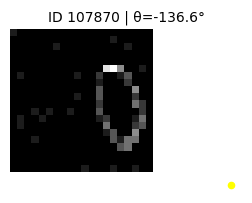

Image ID: 593379
cx=20.84, cy=23.18
lxx=102.799, lxy=202.231, lyy=-20.505
Derived: a=15.892, b=nan, θ=-143.48°



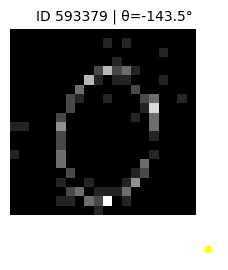

Image ID: 107328
cx=27.56, cy=22.73
lxx=100.054, lxy=89.629, lyy=62.716
Derived: a=13.151, b=nan, θ=-140.88°



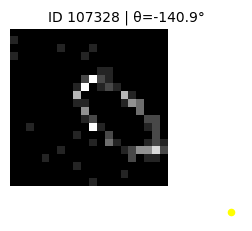

Image ID: 81289
cx=14.85, cy=21.91
lxx=99.616, lxy=73.563, lyy=37.513
Derived: a=12.182, b=nan, θ=-146.44°



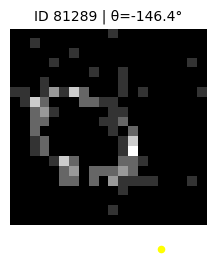

Image ID: 411672
cx=32.32, cy=19.47
lxx=37.459, lxy=138.719, lyy=12.333
Derived: a=12.813, b=nan, θ=-137.59°



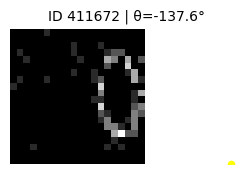

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

#  Function to compute a,b,theta from covariance matrix 
def ellipse_from_covariance(l1, l2, l3):
    """
    Given covariance matrix elements (l1=lxx, l2=lxy, l3=lyy),
    return (a, b, theta):
    - a: semi-major axis length
    - b: semi-minor axis length
    - theta: orientation angle in degrees
    """
    cov = np.array([[l1, l2],
                    [l2, l3]])

    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    # Sort eigenvalues descending
    order = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    a, b = np.sqrt(eigenvalues)
    theta = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    return a, b, theta


#  Visualize few random samples 
num_samples = 5  # how many ellipses to visualize
indices = random.sample(range(len(dataset)), num_samples)

for idx in indices:
    sample = dataset[idx]
    img = sample["image"].permute(1, 2, 0).numpy()
    params = sample["params"].numpy()
    cx, cy = params[0], params[1]
    l1, l2, l3 = params[2], params[3], params[4]

    a, b, theta = ellipse_from_covariance(l1, l2, l3)

    print(f"Image ID: {sample['image_id']}")
    print(f"cx={cx:.2f}, cy={cy:.2f}")
    print(f"lxx={l1:.3f}, lxy={l2:.3f}, lyy={l3:.3f}")
    print(f"Derived: a={a:.3f}, b={b:.3f}, θ={theta:.2f}°\n")

    # Plot image + ellipse outline 
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img, cmap="gray")
    ax.set_title(f"ID {sample['image_id']} | θ={theta:.1f}°", fontsize=10)

    # Create the ellipse outline using derived values
    ellipse = patches.Ellipse(
        (cx, cy), width=2*a, height=2*b, angle=theta,
        edgecolor="red", facecolor="none", linewidth=2
    )
    ax.add_patch(ellipse)
    ax.scatter(cx, cy, color="yellow", s=20)  # mark center
    ax.set_axis_off()
    plt.show()


In [8]:

#  Baseline Inference  (GPU if available, else CPU)

import torch
import sys

# Determine device: prefer an existing `device` or `select_device()` helper if present,
# otherwise choose CUDA if available else CPU. This prints informative messages.
_device = globals().get('device', None)
if _device is not None:
    device = _device
else:
    sel = globals().get('select_device', None)
    if callable(sel):
        try:
            device = sel()
        except Exception as e:
            print('select_device() failed, falling back to torch defaults:', e)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        # No helper: prefer CUDA if available. Print device properties when possible.
        if torch.cuda.is_available():
            try:
                prop = torch.cuda.get_device_properties(0)
                print(f'CUDA available: {prop.name} compute {prop.major}.{prop.minor}')
            except Exception as e:
                print('Could not query CUDA device properties:', e)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')

print(f'Using device: {device}')

# Initialize model and move to the selected device
model = EllipseRegressionModel().to(device)
model.eval()

# Load a small batch and move it to the selected device
batch = next(iter(train_loader))
batch = move_batch_to_device(batch, device)
images = batch['image']
targets = batch['params']

# Run inference
with torch.no_grad():
    outputs = model(images)

print(' Inference ran successfully!')
print('Predictions shape:', outputs.shape)
print('Sample prediction:', outputs[0])
print('Sample target:', targets[0])


Using device: cuda


 Inference ran successfully!
Predictions shape: torch.Size([64, 5])
Sample prediction: tensor([ 0.0769, -0.0429,  0.0752, -0.0306, -0.0525], device='cuda:0')
Sample target: tensor([ 17.9915,  14.1274, 146.8601, 122.5806,  42.4954], device='cuda:0')


Evaluation will run on device: cpu
MAE per output (cx,cy,lxx,lxy,lyy): [20.019699096679688, 19.959365844726562, 136.2263641357422, 136.44381713867188, 34.02322006225586]
RMSE per output (cx,cy,lxx,lxy,lyy): [20.5445499420166, 20.483917236328125, 148.67153930664062, 148.89068603515625, 46.005924224853516]
Mean MAE: 69.3344955444336 Mean RMSE: 76.91932678222656
Denorm MAE (lxx,lxy,lyy) [units]: [54490.54296875, 54577.51953125, 13609.2900390625]
Denorm RMSE (lxx,lxy,lyy) [units]: [59468.61328125, 59556.26953125, 18402.37109375]

First 5 examples (pred -> target):
[0] pred: [-0.01277219  0.05290179 -0.05705794  0.03056042 -0.05765831]  target: [ 17.053455  19.505548 122.48734  301.4743   -37.78536 ]
[1] pred: [-0.01268592  0.05314273 -0.05754078  0.0309974  -0.05755211]  target: [ 20.991274  22.024527 286.93402  314.30096  -33.54171 ]
[2] pred: [-0.01266236  0.05330138 -0.05789994  0.03064733 -0.05780177]  target: [ 18.624212  16.483942  60.108997 205.25464  -65.70538 ]
[3] pred: [-0.01267

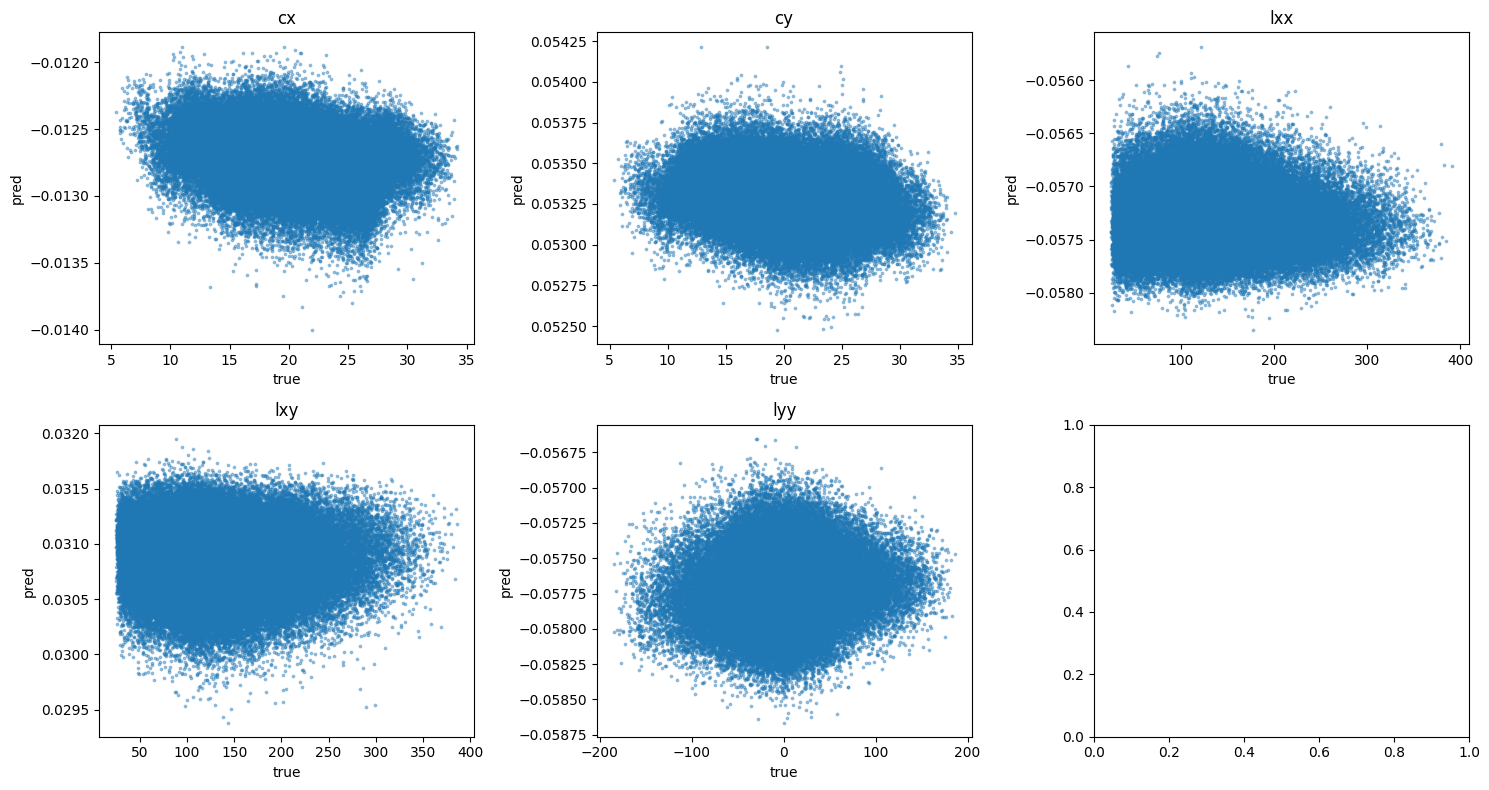

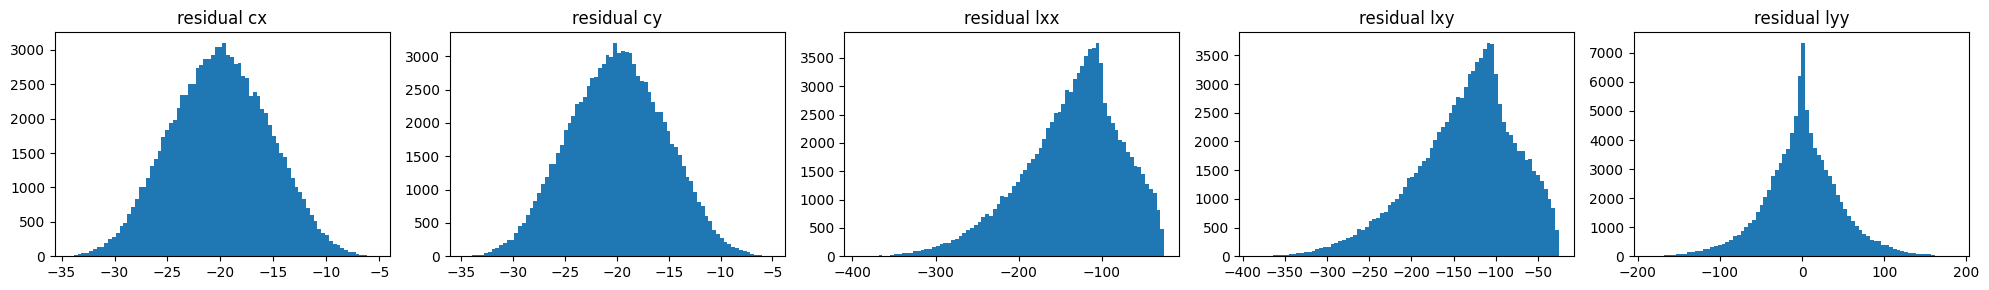

Evaluation complete.


In [12]:
# Evaluation: MAE / RMSE + diagnostic plots
# Runs the model over `val_loader` and prints per-output and overall metrics.
import torch
import numpy as np

# Determine device (prefer existing `device` or fall back)
device = globals().get('device') if globals().get('device', None) is not None else (select_device() if globals().get('select_device', None) else (torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
print('Evaluation will run on device:', device)

model = EllipseRegressionModel().to(device)
model.eval()

# Collect predictions and targets (keep on CPU to reduce GPU memory)
preds_list = []
tgt_list = []
with torch.no_grad():
    for batch in val_loader:
        batch = move_batch_to_device(batch, device)
        out = model(batch['image'])
        preds_list.append(out.cpu())
        tgt_list.append(batch['params'].cpu())

preds = torch.cat(preds_list, dim=0)
tgt = torch.cat(tgt_list, dim=0)

# Per-output metrics
diff = preds - tgt
mae_per = torch.mean(diff.abs(), dim=0)
rmse_per = torch.sqrt(torch.mean(diff**2, dim=0))
print('MAE per output (cx,cy,lxx,lxy,lyy):', mae_per.tolist())
print('RMSE per output (cx,cy,lxx,lxy,lyy):', rmse_per.tolist())
print('Mean MAE:', float(mae_per.mean()), 'Mean RMSE:', float(rmse_per.mean()))

# If l1/l2/l3 were normalized by 400 in the dataset, show denormalized metrics for those outputs
try:
    # assume normalization used: l1,l2,l3 divided by 400
    denorm_preds = preds.clone()
    denorm_tgt = tgt.clone()
    denorm_preds[:,2:5] *= 400.0
    denorm_tgt[:,2:5] *= 400.0
    denorm_diff = denorm_preds - denorm_tgt
    denorm_mae = torch.mean(denorm_diff.abs(), dim=0)
    denorm_rmse = torch.sqrt(torch.mean(denorm_diff**2, dim=0))
    print('Denorm MAE (lxx,lxy,lyy) [units]:', denorm_mae[2:5].tolist())
    print('Denorm RMSE (lxx,lxy,lyy) [units]:', denorm_rmse[2:5].tolist())
except Exception:
    pass

# Print a small table of samples: true vs pred for first 5 examples
n_show = min(5, preds.shape[0])
print(f'\nFirst {n_show} examples (pred -> target):')
for i in range(n_show):
    print(f'[{i}] pred:', preds[i].numpy(), ' target:', tgt[i].numpy())

# Diagnostic plots (scatter + residual histograms) if matplotlib is available
try:
    import matplotlib.pyplot as plt
    import math
    preds_np = preds.numpy()
    tgt_np = tgt.numpy()
    # Scatter for cx and cx residuals
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()
    labels = ['cx', 'cy', 'lxx', 'lxy', 'lyy']
    for j in range(5):
        axes[j].scatter(tgt_np[:, j], preds_np[:, j], s=3, alpha=0.4)
        axes[j].set_title(labels[j])
        axes[j].set_xlabel('true')
        axes[j].set_ylabel('pred')
    plt.tight_layout()
    plt.show()
    # Residual histograms for each output (include cx and cy as well)
    fig2, axes2 = plt.subplots(1, 5, figsize=(20, 3))
    for k in range(5):
        axes2[k].hist((preds_np[:, k]-tgt_np[:, k]), bins=80)
        axes2[k].set_title(f'residual {labels[k]}')
    plt.tight_layout(); plt.show()
except Exception as e:
    print('Matplotlib unavailable or plotting failed:', e)

print('Evaluation complete.')


In [36]:

#  FP32 TRAINING LOOP 

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Step: Device selection (safe fallback)
GPU_MIN_ARCH = globals().get('GPU_MIN_ARCH', 70)
try:
    device = select_device(min_arch=GPU_MIN_ARCH)
except Exception as e:
    print('select_device() unavailable or failed, using torch default:', e)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

globals()['device'] = device
print("Using device:", device)

# Step: Model and Loss
model = EllipseRegressionModel().to(device)

# Use SmoothL1Loss if available, else fallback to MSELoss
try:
    loss_fn = nn.SmoothL1Loss()
    loss_name = "SmoothL1Loss"
except AttributeError:
    loss_fn = nn.MSELoss()
    loss_name = "MSELoss"

loss_fn = loss_fn.to(device)
print("Using loss:", loss_name)

# Step: Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Reduce learning rate when validation loss stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
if hasattr(scheduler, 'verbose'):
    scheduler.verbose = True  # only works on newer PyTorch versions

# Step: Training parameters
num_epochs = 150
best_val_loss = float('inf')
best_epoch = 0

print("\n Starting FP32 training...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    #  Training Loop 
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = batch['image'].to(device)
        targets = batch['params'].to(device)

        # Normalize covariance matrix terms (l1, l2, l3)
        targets_norm = targets.clone()
        targets_norm[:, 2:] /= 400.0

        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, targets_norm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    #  Validation Loop
    model.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            targets = batch['params'].to(device)

            tgt_norm = targets.clone()
            tgt_norm[:, 2:] /= 400.0

            preds = model(images)
            vloss = loss_fn(preds, tgt_norm)
            val_loss_total += vloss.item() * images.size(0)

    avg_val_loss = val_loss_total / len(val_loader.dataset)

    # Scheduler update (adjust learning rate)
    scheduler.step(avg_val_loss)
    print(f"→ Scheduler adjusted LR: {optimizer.param_groups[0]['lr']:.2e}")

    #  Epoch Summary 
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Save best model 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "ellipse_fp32_best.pth")
        print(f" Saved best model at epoch {best_epoch} (val loss {best_val_loss:.6f})")

print(f"\n Training complete! Best val loss {best_val_loss:.6f} at epoch {best_epoch}.")


GPU NVIDIA GeForce MX330 compute capability 6.1 < required 7.0; using CPU
Using device: cpu
Using loss: SmoothL1Loss

 Starting FP32 training...



Epoch 1/150:   1%|          | 116/12500 [00:06<11:00, 18.76it/s]


KeyboardInterrupt: 

In [12]:

# Cell: Save FP32 Trained Model


# Save final model (last epoch)
torch.save(model.state_dict(), "ellipse_fp32_final.pth")
print("FP32 model (final epoch) saved as 'ellipse_fp32_final.pth'")



FP32 model (final epoch) saved as 'ellipse_fp32_final.pth'


In [13]:
#  Cell: Load FP32 Model for Inference (with target normalization)

import torch

# Define the model architecture (must match training)
model = EllipseRegressionModel()

# Load saved weights
checkpoint_path = "ellipse_fp32_best.pth"  # or "ellipse_fp32_final.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))  # device = 'cpu' or 'cuda'

# Move model to the selected device and set to eval
model = model.to(device)
model.eval()

print(f"FP32 model loaded from '{checkpoint_path}' and ready for inference on device {device}.")

# Quick inference test on one batch 
batch = next(iter(test_loader))  # use your test DataLoader

images = batch["image"].to(device)
targets = batch["params"].to(device)

# 🔹 Normalize l1, l2, l3 of the targets (same scaling used during training)
targets[:, 2:] = targets[:, 2:] / 400.0

# Run inference
with torch.no_grad():
    preds = model(images)

# Display results 
print("Predictions shape:", preds.shape)
print("\nFirst 5 predictions (normalized):")
print(preds[:5])

print("\nFirst 5 targets (normalized):")
print(targets[:5])

# Optional: Mean absolute difference just for a quick sanity check
mae = torch.mean(torch.abs(preds - targets), dim=0)
print("\nQuick MAE per parameter (cx, cy, lxx, lxy, lyy):", mae.cpu().numpy())


FP32 model loaded from 'ellipse_fp32_best.pth' and ready for inference on device cpu.


Predictions shape: torch.Size([64, 5])

First 5 predictions (normalized):
tensor([[ 2.4233e+01,  2.4755e+01,  4.0703e-01,  2.4775e-01, -2.5006e-01],
        [ 1.4269e+01,  2.1187e+01,  4.1561e-01,  2.8922e-01, -1.4452e-01],
        [ 2.0670e+01,  1.1435e+01,  2.3304e-01,  2.3785e-01,  1.6638e-02],
        [ 2.1071e+01,  2.6063e+01,  7.7190e-02,  3.4772e-01, -1.7780e-03],
        [ 2.0162e+01,  2.6798e+01,  3.7263e-01,  9.6187e-02, -2.2180e-02]])

First 5 targets (normalized):
tensor([[ 2.3987e+01,  2.4945e+01,  4.2623e-01,  2.4202e-01, -2.2954e-01],
        [ 1.4291e+01,  2.1354e+01,  4.1769e-01,  3.0735e-01, -1.4953e-01],
        [ 2.0777e+01,  1.1279e+01,  2.1795e-01,  2.2688e-01,  3.5830e-02],
        [ 2.0906e+01,  2.6132e+01,  7.4180e-02,  3.5909e-01,  7.5796e-04],
        [ 1.9859e+01,  2.6889e+01,  3.8041e-01,  8.3562e-02, -1.1577e-02]])

Quick MAE per parameter (cx, cy, lxx, lxy, lyy): [0.18635255 0.13579728 0.01288562 0.01567286 0.01288425]


Evaluating FP32 model: 100%|██████████| 1563/1563 [00:29<00:00, 53.32it/s]


Median magnitudes (pred l1,l2,l3): [0.31559765 0.32948142 0.06284426]
Median magnitudes (tgt  l1,l2,l3): [128.21736 128.37051  25.67974]
-> predictions l looks normalized (median 0.249); applying *400.0 denorm factor.
-> targets l looks already denormalized (median 99.079); leaving as-is.
Median cx pred=20.044, tgt=20.003

MAE per output (cx, cy, lxx, lxy, lyy) [denorm units]: [0.17240979 0.17238401 6.1595716  6.5444627  4.956503  ]
RMSE per output (cx, cy, lxx, lxy, lyy) [denorm units]: [0.22326817 0.22294874 8.067955   8.37421    6.45905   ]
Mean MAE: 3.601066, Mean RMSE: 4.669486



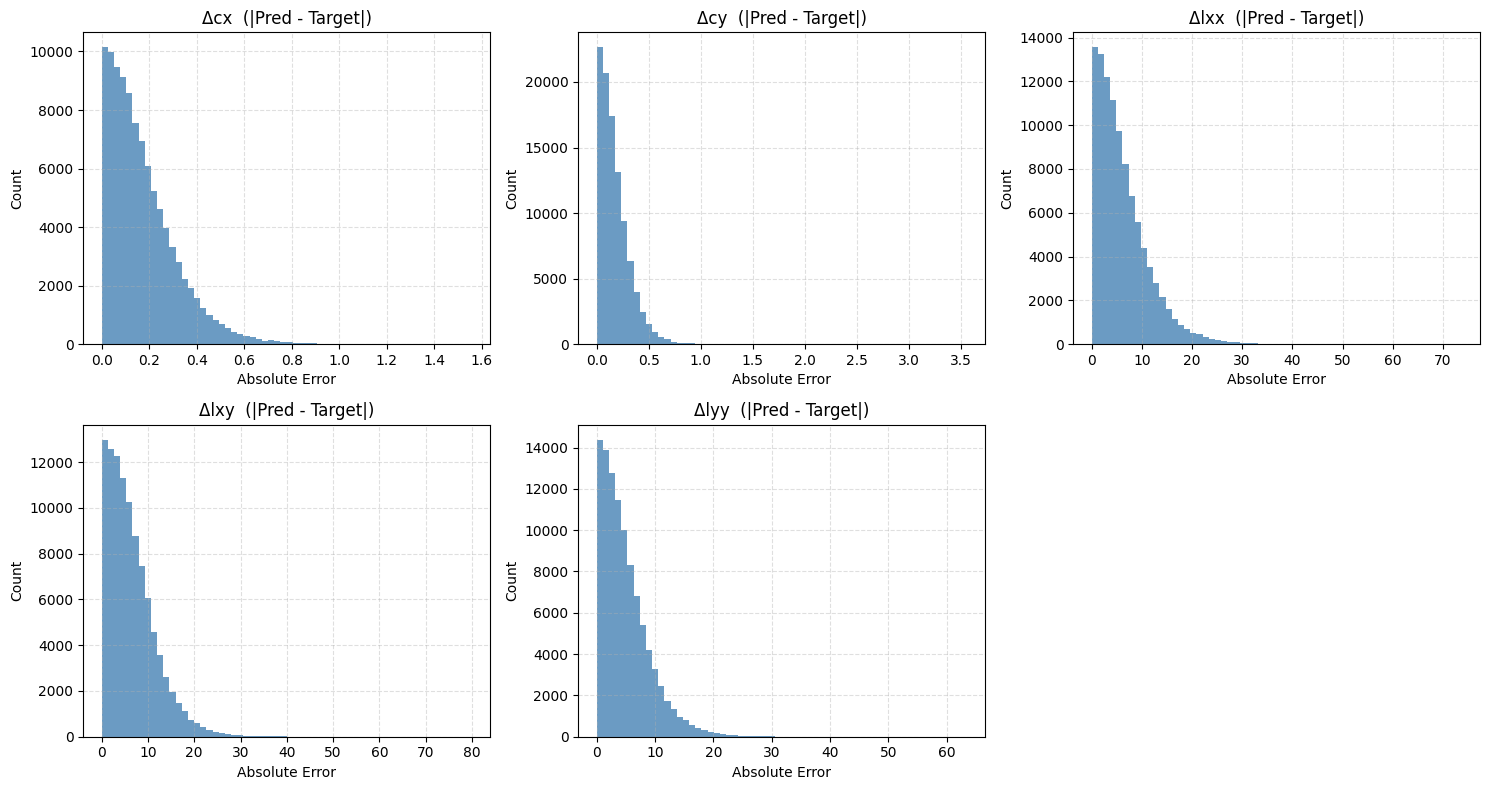

Δcx: mean Δ=0.172, std=0.142, max Δ=1.557
Δcy: mean Δ=0.172, std=0.141, max Δ=3.553
Δlxx: mean Δ=6.160, std=5.211, max Δ=73.710
Δlxy: mean Δ=6.544, std=5.225, max Δ=79.884
Δlyy: mean Δ=4.957, std=4.142, max Δ=63.416


In [14]:

# Cell: Evaluate FP32 Model + Δ (Delta) Histograms


import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

DENORM = 400.0  # the factor used during training: targets[:,2:] /= DENORM

model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets (raw from model and dataset)
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating FP32 model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)   # dataset-provided values (likely raw)
        preds = model(images)                  # model outputs (likely normalized for l1,l2,l3)

        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Diagnostics: inspect typical magnitudes for covariance components
pred_l_med = np.median(np.abs(all_preds[:, 2:]), axis=0)
tgt_l_med = np.median(np.abs(all_targets[:, 2:]), axis=0)
print("Median magnitudes (pred l1,l2,l3):", pred_l_med)
print("Median magnitudes (tgt  l1,l2,l3):", tgt_l_med)

# Heuristic to decide if values are normalized (≈O(1)) or already denormalized (>>1)
def maybe_denorm(arr, name):
    """If arr's median magnitude is small (<=5), assume it's normalized and denorm it."""
    med = np.median(np.abs(arr))
    if med <= 5.0:
        print(f"-> {name} looks normalized (median {med:.3f}); applying *{DENORM} denorm factor.")
        return arr * DENORM, True
    else:
        print(f"-> {name} looks already denormalized (median {med:.3f}); leaving as-is.")
        return arr, False

# Apply detection & denormalization for covariance parts separately for preds & targets
# Work on copies to avoid accidental double multiplication
preds_work = all_preds.copy()
targs_work = all_targets.copy()

# Denormalize l1,l2,l3 if needed
preds_work[:, 2:], pred_denormed = maybe_denorm(preds_work[:, 2:], "predictions l")
targs_work[:, 2:], targ_denormed = maybe_denorm(targs_work[:, 2:], "targets l")

# (Optional) If cx/cy appear normalized (very small), print a warning; we don't auto-scale cx/cy
cx_med_pred = np.median(np.abs(preds_work[:,0]))
cx_med_targ = np.median(np.abs(targs_work[:,0]))
print(f"Median cx pred={cx_med_pred:.3f}, tgt={cx_med_targ:.3f}")
if np.median(np.abs(preds_work[:, :2])) <= 5.0 and np.median(np.abs(all_targets[:, :2])) > 5.0:
    print("Note: predictions cx/cy look small while targets are large — check coordinate frames.")
# We avoid guessing for cx/cy scaling automatically to prevent incorrect rescaling.

# Now compute absolute differences (denormalized)
delta = np.abs(preds_work - targs_work)

# Compute MAE and RMSE based on the (now) denormalized arrays
mae_per_output = np.mean(delta, axis=0)
rmse_per_output = np.sqrt(np.mean((preds_work - targs_work) ** 2, axis=0))
mean_mae = np.mean(mae_per_output)
mean_rmse = np.mean(rmse_per_output)

print("\nMAE per output (cx, cy, lxx, lxy, lyy) [denorm units]:", mae_per_output)
print("RMSE per output (cx, cy, lxx, lxy, lyy) [denorm units]:", rmse_per_output)
print(f"Mean MAE: {mean_mae:.6f}, Mean RMSE: {mean_rmse:.6f}\n")

# Plot histograms of absolute errors (Δ)
output_names = ["Δcx", "Δcy", "Δlxx", "Δlxy", "Δlyy"]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, name in enumerate(output_names):
    axes[i].hist(delta[:, i], bins=60, color="steelblue", alpha=0.8)
    axes[i].set_title(f"{name}  (|Pred - Target|)")
    axes[i].set_xlabel("Absolute Error")
    axes[i].set_ylabel("Count")
    axes[i].grid(True, linestyle="--", alpha=0.4)

# Hide extra subplot
if len(output_names) < len(axes):
    for j in range(len(output_names), len(axes)):
        axes[j].axis("off")

plt.tight_layout()
plt.show()

# Print summary stats
for i, name in enumerate(output_names):
    print(f"{name}: mean Δ={delta[:, i].mean():.3f}, std={delta[:, i].std():.3f}, max Δ={delta[:, i].max():.3f}")


In [15]:

# Cell: Evaluate FP32 Model — MAE, RMSE, r, R²


import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        
        preds = model(images)
        
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate and convert to numpy
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Denormalize covariance terms (l1, l2, l3)
all_preds[:, 2:] *= 400.0
#all_targets[:, 2:] *= 400.0

# Compute metrics
mae = mean_absolute_error(all_targets, all_preds, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(all_targets, all_preds, multioutput='raw_values'))
r2 = r2_score(all_targets, all_preds, multioutput='raw_values')

pearson_r = []
for i in range(all_preds.shape[1]):
    r, _ = pearsonr(all_targets[:, i], all_preds[:, i])
    pearson_r.append(r)
pearson_r = np.array(pearson_r)

# Pretty report
output_names = ["cx", "cy", "lxx", "lxy", "lyy"]

print("\nMODEL PERFORMANCE METRICS \n")
for i, name in enumerate(output_names):
    print(f"{name}:")
    print(f"  MAE   = {mae[i]:.4f}")
    print(f"  RMSE  = {rmse[i]:.4f}")
    print(f"  r     = {pearson_r[i]:.4f}")
    print(f"  R²    = {r2[i]:.4f}")
    #print("-" * 35)

print(f"\nMean MAE  : {mae.mean():.4f}")
print(f"Mean RMSE : {rmse.mean():.4f}")
print(f"Mean r    : {pearson_r.mean():.4f}")
print(f"Mean R²   : {r2.mean():.4f}")


Evaluating model: 100%|██████████| 1563/1563 [00:29<00:00, 53.46it/s]


MODEL PERFORMANCE METRICS 

cx:
  MAE   = 0.1724
  RMSE  = 0.2233
  r     = 0.9989
  R²    = 0.9977
cy:
  MAE   = 0.1724
  RMSE  = 0.2229
  r     = 0.9989
  R²    = 0.9977
lxx:
  MAE   = 6.1596
  RMSE  = 8.0680
  r     = 0.9913
  R²    = 0.9817
lxy:
  MAE   = 6.5445
  RMSE  = 8.3742
  r     = 0.9916
  R²    = 0.9802
lyy:
  MAE   = 4.9565
  RMSE  = 6.4591
  r     = 0.9905
  R²    = 0.9802

Mean MAE  : 3.6011
Mean RMSE : 4.6695
Mean r    : 0.9942
Mean R²   : 0.9875


In [16]:

# Evaluate Model — Relative Error (%)


import numpy as np
import torch
from tqdm import tqdm

model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collecting predictions"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        
        preds = model(images)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Denormalize covariance components (l1, l2, l3)
all_preds[:, 2:] *= 400.0
#all_targets[:, 2:] *= 400.0

# Compute absolute errors
abs_error = np.abs(all_preds - all_targets)

# Compute relative errors (%)
rel_error = abs_error / (np.abs(all_targets) + 1e-8) * 100  # add small epsilon to avoid division by zero

# Summary stats
output_names = ["cx", "cy", "lxx", "lxy", "lyy"]
for i, name in enumerate(output_names):
    mean_rel = np.mean(rel_error[:, i])
    max_rel = np.max(rel_error[:, i])
    print(f"{name}: mean relative error = {mean_rel:.2f}%") #, max relative error = {max_rel:.2f}%")


cx: mean relative error = 0.92%
cy: mean relative error = 0.92%
lxx: mean relative error = 5.22%
lxy: mean relative error = 5.82%
lyy: mean relative error = 691.00%


In [10]:

# Initialize from FP32 weights (for QAT)


import torch
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU

# Load FP32 weights
fp32_checkpoint = "ellipse_fp32_best.pth"
fp32_model = EllipseRegressionModel()
fp32_model.load_state_dict(torch.load(fp32_checkpoint, map_location='cpu'))
fp32_model.eval()

print(f"Loaded FP32 weights from '{fp32_checkpoint}'")


Loaded FP32 weights from 'ellipse_fp32_best.pth'


In [11]:
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFloat
import torch.nn as nn

class QuantizedEllipseRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = QuantConv2d(1, 32, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = QuantConv2d(32, 64, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = QuantConv2d(64, 128, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = QuantConv2d(128, 256, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2)
        self.act = QuantReLU(bit_width=8)
        
        self.fc1 = QuantLinear(256*1*1, 512, weight_bit_width=8, bias=False)
        self.fc2 = QuantLinear(512, 256, weight_bit_width=8, bias=False)
        self.fc_out = QuantLinear(256, 5, weight_bit_width=8, bias=False)

    def forward(self, x):
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = self.pool(self.act(self.bn2(self.conv2(x))))
        x = self.pool(self.act(self.bn3(self.conv3(x))))
        x = self.pool(self.act(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.fc_out(x)


In [12]:

#  Initialize Quantized Model from FP32 Weights


import torch

# Load your trained FP32 model weights (make sure path is correct)
fp32_model_path = "ellipse_fp32_best.pth"
fp32_model = EllipseRegressionModel().to(device)
fp32_model.load_state_dict(torch.load(fp32_model_path, map_location=device))
fp32_model.eval()

# Initialize quantized model
q_model = QuantizedEllipseRegressionModel().to(device)

# Copy FP32 weights layer by layer
with torch.no_grad():
    # Conv layers
    q_model.conv1.weight.copy_(fp32_model.conv1.weight)
    q_model.conv2.weight.copy_(fp32_model.conv2.weight)
    q_model.conv3.weight.copy_(fp32_model.conv3.weight)
    q_model.conv4.weight.copy_(fp32_model.conv4.weight)

    # BatchNorm layers
    q_model.bn1.load_state_dict(fp32_model.bn1.state_dict())
    q_model.bn2.load_state_dict(fp32_model.bn2.state_dict())
    q_model.bn3.load_state_dict(fp32_model.bn3.state_dict())
    q_model.bn4.load_state_dict(fp32_model.bn4.state_dict())

    # Fully connected layers
    q_model.fc1.weight.copy_(fp32_model.fc1.weight)
    q_model.fc2.weight.copy_(fp32_model.fc2.weight)
    q_model.fc_out.weight.copy_(fp32_model.fc_out.weight)

print("Quantized model initialized with FP32 pretrained weights.")


Quantized model initialized with FP32 pretrained weights.


In [ ]:
# Quantization-Aware Training (QAT)


import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# QAT Setup 
num_epochs_qat = 30  # fewer epochs than FP32 training (since weights are initialized)
learning_rate_qat = 1e-4

# Define loss and optimizer
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(q_model.parameters(), lr=learning_rate_qat, weight_decay=1e-5)

# Optional: learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

best_val_loss = float('inf')

print("Starting Quantization-Aware Training...")

for epoch in range(num_epochs_qat):
    q_model.train()
    running_loss = 0.0

    # --- Training loop ---
    for batch in tqdm(train_loader, desc=f"QAT Epoch {epoch+1}/{num_epochs_qat}"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        targets_norm = targets.clone()
        targets_norm[:, 2:] = targets_norm[:, 2:] / 400.0  # normalize l1,l2,l3

        optimizer.zero_grad()
        preds = q_model(images)
        loss = criterion(preds, targets_norm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # --- Validation ---
    q_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            targets = batch["params"].to(device)
            tgt_norm = targets.clone()
            tgt_norm[:, 2:] = tgt_norm[:, 2:] / 400.0
            preds = q_model(images)
            loss = criterion(preds, tgt_norm)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs_qat}]  Train Loss: {avg_train_loss:.6f}  |  Val Loss: {avg_val_loss:.6f}")

    # --- Save best model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(q_model.state_dict(), "ellipse_qat_best.pth")
        print(f"Saved best QAT model (val loss = {best_val_loss:.6f})")

print("QAT training complete!")

Starting Quantization-Aware Training...


QAT Epoch 1/30: 100%|██████████| 12500/12500 [01:50<00:00, 112.66it/s]


Epoch [1/30]  Train Loss: 0.010244  |  Val Loss: 0.009688
Saved best QAT model (val loss = 0.009688)


QAT Epoch 2/30: 100%|██████████| 12500/12500 [01:50<00:00, 112.68it/s]


Epoch [2/30]  Train Loss: 0.010087  |  Val Loss: 0.010464


QAT Epoch 3/30: 100%|██████████| 12500/12500 [01:52<00:00, 111.13it/s]


Epoch [3/30]  Train Loss: 0.009993  |  Val Loss: 0.012548


QAT Epoch 4/30: 100%|██████████| 12500/12500 [01:50<00:00, 112.70it/s]


Epoch [4/30]  Train Loss: 0.009934  |  Val Loss: 0.010239


QAT Epoch 5/30: 100%|██████████| 12500/12500 [01:46<00:00, 117.07it/s]


Epoch [5/30]  Train Loss: 0.009858  |  Val Loss: 0.010280


QAT Epoch 6/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.17it/s]


Epoch [6/30]  Train Loss: 0.009800  |  Val Loss: 0.012147


QAT Epoch 7/30: 100%|██████████| 12500/12500 [01:45<00:00, 118.61it/s]


Epoch [7/30]  Train Loss: 0.009769  |  Val Loss: 0.010337


QAT Epoch 8/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.63it/s]


Epoch [8/30]  Train Loss: 0.008856  |  Val Loss: 0.009566
Saved best QAT model (val loss = 0.009566)


QAT Epoch 9/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.02it/s]


Epoch [9/30]  Train Loss: 0.008810  |  Val Loss: 0.009169
Saved best QAT model (val loss = 0.009169)


QAT Epoch 10/30: 100%|██████████| 12500/12500 [01:45<00:00, 118.34it/s]


Epoch [10/30]  Train Loss: 0.008779  |  Val Loss: 0.009299


QAT Epoch 11/30: 100%|██████████| 12500/12500 [01:46<00:00, 116.84it/s]


Epoch [11/30]  Train Loss: 0.008743  |  Val Loss: 0.009428


QAT Epoch 12/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.25it/s]


Epoch [12/30]  Train Loss: 0.008725  |  Val Loss: 0.008985
Saved best QAT model (val loss = 0.008985)


QAT Epoch 13/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.73it/s]


Epoch [13/30]  Train Loss: 0.008708  |  Val Loss: 0.009026


QAT Epoch 14/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.71it/s]


Epoch [14/30]  Train Loss: 0.008673  |  Val Loss: 0.009767


QAT Epoch 15/30: 100%|██████████| 12500/12500 [01:48<00:00, 114.88it/s]


Epoch [15/30]  Train Loss: 0.008684  |  Val Loss: 0.009118


QAT Epoch 16/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.75it/s]


Epoch [16/30]  Train Loss: 0.008661  |  Val Loss: 0.009186


QAT Epoch 17/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.37it/s]


Epoch [17/30]  Train Loss: 0.008637  |  Val Loss: 0.009289


QAT Epoch 18/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.66it/s]


Epoch [18/30]  Train Loss: 0.008635  |  Val Loss: 0.009754


QAT Epoch 19/30: 100%|██████████| 12500/12500 [01:48<00:00, 114.76it/s]


Epoch [19/30]  Train Loss: 0.008123  |  Val Loss: 0.009060


QAT Epoch 20/30: 100%|██████████| 12500/12500 [01:45<00:00, 117.95it/s]


Epoch [20/30]  Train Loss: 0.008092  |  Val Loss: 0.009645


QAT Epoch 21/30: 100%|██████████| 12500/12500 [01:47<00:00, 115.76it/s]


Epoch [21/30]  Train Loss: 0.008072  |  Val Loss: 0.009160


QAT Epoch 22/30: 100%|██████████| 12500/12500 [01:47<00:00, 115.79it/s]


Epoch [22/30]  Train Loss: 0.008055  |  Val Loss: 0.009225


QAT Epoch 23/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.63it/s]


Epoch [23/30]  Train Loss: 0.008048  |  Val Loss: 0.008933
Saved best QAT model (val loss = 0.008933)


QAT Epoch 24/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.07it/s]


Epoch [24/30]  Train Loss: 0.008030  |  Val Loss: 0.009169


QAT Epoch 25/30: 100%|██████████| 12500/12500 [01:46<00:00, 117.23it/s]


Epoch [25/30]  Train Loss: 0.008025  |  Val Loss: 0.009478


QAT Epoch 26/30: 100%|██████████| 12500/12500 [01:49<00:00, 114.43it/s]


Epoch [26/30]  Train Loss: 0.008016  |  Val Loss: 0.009066


QAT Epoch 27/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.70it/s]


Epoch [27/30]  Train Loss: 0.008004  |  Val Loss: 0.008859
Saved best QAT model (val loss = 0.008859)


QAT Epoch 28/30: 100%|██████████| 12500/12500 [01:46<00:00, 116.95it/s]


Epoch [28/30]  Train Loss: 0.007988  |  Val Loss: 0.008990


QAT Epoch 29/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.42it/s]


Epoch [29/30]  Train Loss: 0.007975  |  Val Loss: 0.009081


QAT Epoch 30/30: 100%|██████████| 12500/12500 [01:50<00:00, 112.99it/s]


Epoch [30/30]  Train Loss: 0.007960  |  Val Loss: 0.008909
QAT training complete!


In [13]:
# Load Trained QAT Model Checkpoint

import torch

# Load the trained QAT model weights
qat_checkpoint_path = "ellipse_qat_best.pth"
q_model.load_state_dict(torch.load(qat_checkpoint_path, map_location=device))
q_model.eval()

print(f"✅ Loaded trained QAT model from: {qat_checkpoint_path}")
print(f"   Model is ready for evaluation!")

✅ Loaded trained QAT model from: ellipse_qat_best.pth
   Model is ready for evaluation!


In [43]:

# Evaluate QAT Model — MAE, RMSE, r, R²


import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

q_model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating QAT model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        preds = q_model(images)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Denormalize covariance terms
all_preds[:, 2:] *= 400.0
#all_targets[:, 2:] *= 400.0

mae = mean_absolute_error(all_targets, all_preds, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(all_targets, all_preds, multioutput='raw_values'))
r2 = r2_score(all_targets, all_preds, multioutput='raw_values')
pearson_r = [pearsonr(all_targets[:, i], all_preds[:, i])[0] for i in range(5)]

names = ["cx", "cy", "lxx", "lxy", "lyy"]
print("\n QAT MODEL PERFORMANCE \n")
for i, n in enumerate(names):
    print(f"{n}: MAE={mae[i]:.4f}, RMSE={rmse[i]:.4f}, r={pearson_r[i]:.4f}, R²={r2[i]:.4f}")


Evaluating QAT model: 100%|██████████| 1563/1563 [01:04<00:00, 24.28it/s]




 QAT MODEL PERFORMANCE 

cx: MAE=0.1517, RMSE=0.1964, r=0.9991, R²=0.9982
cy: MAE=0.1532, RMSE=0.1991, r=0.9991, R²=0.9981
lxx: MAE=5.4257, RMSE=7.1940, r=0.9928, R²=0.9854
lxy: MAE=6.9376, RMSE=8.7324, r=0.9928, R²=0.9785
lyy: MAE=4.5166, RMSE=5.9072, r=0.9918, R²=0.9834


Evaluating QAT model:   0%|          | 0/1563 [00:00<?, ?it/s]/home/hritik/miniconda3/envs/ellipse-qat/lib/python3.11/site-packages/torch/_tensor.py:1630: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1971.)
  return super().rename(names)
Evaluating QAT model: 100%|██████████| 1563/1563 [00:08<00:00, 178.93it/s]


Median magnitudes (pred lxx,lxy,lyy): [0.3185799  0.33401942 0.06366329]
Median magnitudes (tgt  lxx,lxy,lyy): [128.15015 128.24951  25.55199]
-> predictions l looks normalized (median 0.252); applying *400.0 factor.
-> targets l looks already denormalized (median 99.318); leaving as-is.
Median cx pred=19.976, tgt=19.991

MAE per output (cx, cy, lxx, lxy, lyy) [denorm units]: [0.1514551  0.15263906 5.400841   6.9504337  4.5224357 ]
RMSE per output (cx, cy, lxx, lxy, lyy) [denorm units]: [0.19657905 0.19841434 7.148498   8.77295    5.9016004 ]
Mean MAE: 3.435561, Mean RMSE: 4.443608



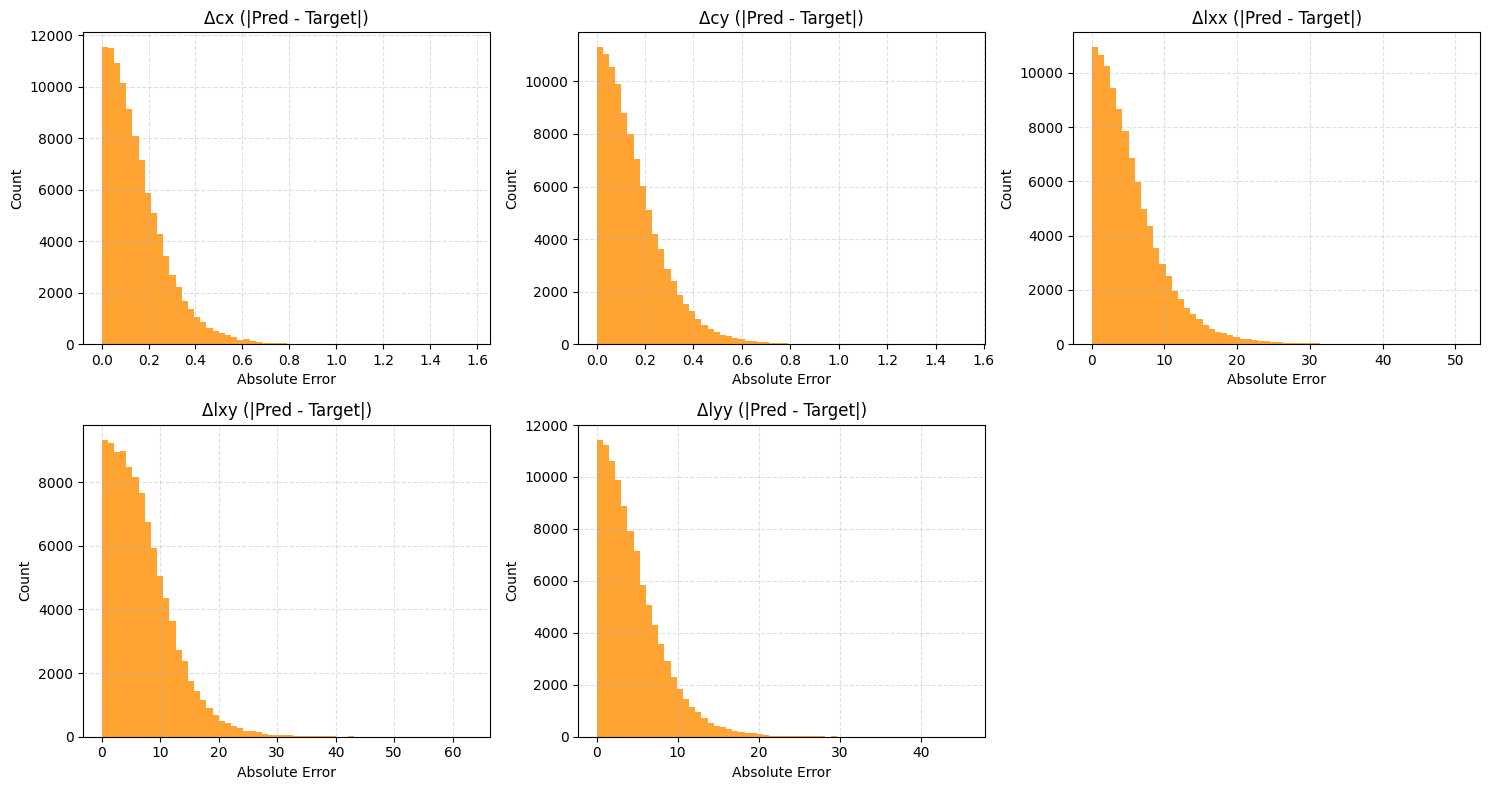

Δcx: mean Δ=0.151, std=0.125, max Δ=1.576
Δcy: mean Δ=0.153, std=0.127, max Δ=1.528
Δlxx: mean Δ=5.401, std=4.683, max Δ=50.830
Δlxy: mean Δ=6.950, std=5.353, max Δ=63.232
Δlyy: mean Δ=4.522, std=3.792, max Δ=45.631


In [14]:

# Evaluate QAT Model + Δ (Delta) Histograms


import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

DENORM = 400.0  # same factor as used during FP32 training

q_model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating QAT model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        preds = q_model(images)
        
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate into numpy arrays
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Diagnostics: check typical magnitudes for covariance components
pred_l_med = np.median(np.abs(all_preds[:, 2:]), axis=0)
tgt_l_med = np.median(np.abs(all_targets[:, 2:]), axis=0)
print("Median magnitudes (pred lxx,lxy,lyy):", pred_l_med)
print("Median magnitudes (tgt  lxx,lxy,lyy):", tgt_l_med)

def maybe_denorm(arr, name):
    """Auto-detect if normalized; apply denormalization if needed."""
    med = np.median(np.abs(arr))
    if med <= 5.0:
        print(f"-> {name} looks normalized (median {med:.3f}); applying *{DENORM} factor.")
        return arr * DENORM, True
    else:
        print(f"-> {name} looks already denormalized (median {med:.3f}); leaving as-is.")
        return arr, False

# Denormalize covariance terms (l1,l2,l3) if needed
preds_work = all_preds.copy()
targs_work = all_targets.copy()

preds_work[:, 2:], pred_denormed = maybe_denorm(preds_work[:, 2:], "predictions l")
targs_work[:, 2:], targ_denormed = maybe_denorm(targs_work[:, 2:], "targets l")

# Sanity-check cx, cy
cx_med_pred = np.median(np.abs(preds_work[:, 0]))
cx_med_targ = np.median(np.abs(targs_work[:, 0]))
print(f"Median cx pred={cx_med_pred:.3f}, tgt={cx_med_targ:.3f}")

# Compute absolute differences (Δ)
delta = np.abs(preds_work - targs_work)

# Compute MAE and RMSE
mae_per_output = np.mean(delta, axis=0)
rmse_per_output = np.sqrt(np.mean((preds_work - targs_work) ** 2, axis=0))
mean_mae = np.mean(mae_per_output)
mean_rmse = np.mean(rmse_per_output)

print("\nMAE per output (cx, cy, lxx, lxy, lyy) [denorm units]:", mae_per_output)
print("RMSE per output (cx, cy, lxx, lxy, lyy) [denorm units]:", rmse_per_output)
print(f"Mean MAE: {mean_mae:.6f}, Mean RMSE: {mean_rmse:.6f}\n")

# Plot histograms
output_names = ["Δcx", "Δcy", "Δlxx", "Δlxy", "Δlyy"]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, name in enumerate(output_names):
    axes[i].hist(delta[:, i], bins=60, color="darkorange", alpha=0.8)
    axes[i].set_title(f"{name} (|Pred - Target|)")
    axes[i].set_xlabel("Absolute Error")
    axes[i].set_ylabel("Count")
    axes[i].grid(True, linestyle="--", alpha=0.4)

# Hide any unused subplot
if len(output_names) < len(axes):
    for j in range(len(output_names), len(axes)):
        axes[j].axis("off")

plt.tight_layout()
plt.show()

# Print summary stats
for i, name in enumerate(output_names):
    print(f"{name}: mean Δ={delta[:, i].mean():.3f}, std={delta[:, i].std():.3f}, max Δ={delta[:, i].max():.3f}")


In [46]:

# Evaluate QAT Model — Relative Error (%)


import numpy as np
import torch
from tqdm import tqdm

q_model.eval()

all_preds, all_targets = [], []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating QAT model (relative error)"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        
        preds = q_model(images)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate and convert to numpy
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# 🔹 Denormalize only the covariance components (l1, l2, l3)
all_preds[:, 2:] *= 400.0
# all_targets[:, 2:] are already in denormalized form (keep as-is)

# Compute absolute errors
abs_error = np.abs(all_preds - all_targets)

# Compute relative errors (%)
rel_error = abs_error / (np.abs(all_targets) + 1e-8) * 100  # avoid divide by zero

# Summary statistics
output_names = ["cx", "cy", "lxx", "lxy", "lyy"]
print("\n QAT MODEL RELATIVE ERROR (%) \n")

for i, name in enumerate(output_names):
    mean_rel = np.mean(rel_error[:, i])
    max_rel = np.max(rel_error[:, i])
    print(f"{name}: mean relative error = {mean_rel:.2f}%")  #, max relative error = {max_rel:.2f}%")


Evaluating QAT model (relative error): 100%|██████████| 1563/1563 [01:07<00:00, 23.03it/s]

Evaluating QAT model (relative error): 100%|██████████| 1563/1563 [01:07<00:00, 23.03it/s]


 QAT MODEL RELATIVE ERROR (%) 

cx: mean relative error = 0.80%
cy: mean relative error = 0.81%
lxx: mean relative error = 4.46%
lxy: mean relative error = 6.09%
lyy: mean relative error = 424.09%


In [47]:
# Compares FP32 vs QAT on test_loader

import torch, numpy as np
device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load models (paths may differ)
fp32_path = "ellipse_fp32_best.pth"
qat_path  = "ellipse_qat_best.pth"

fp32_model = EllipseRegressionModel().to(device)
fp32_model.load_state_dict(torch.load(fp32_path, map_location=device))
fp32_model.eval()

q_model = QuantizedEllipseRegressionModel().to(device)
q_model.load_state_dict(torch.load(qat_path, map_location=device))
q_model.eval()

all_fp32, all_qat, all_tgt = [], [], []
with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)
        t = batch["params"].cpu().numpy()    # assume dataset targets are in original (denorm) units
        p_fp32 = fp32_model(imgs).cpu().numpy()
        p_qat  = q_model(imgs).cpu().numpy()

        # models likely output normalized covariance (l1,l2,l3) -> denormalize if needed
        # if medians small (<=5) assume normalized; otherwise assume already denorm
        def maybe_denorm(arr):
            if np.median(np.abs(arr[:,2:])) <= 5.0:
                arr = arr.copy()
                arr[:,2:] *= 400.0
            return arr

        all_fp32.append(maybe_denorm(p_fp32))
        all_qat.append(maybe_denorm(p_qat))
        all_tgt.append(t)

all_fp32 = np.concatenate(all_fp32, axis=0)
all_qat  = np.concatenate(all_qat, axis=0)
all_tgt  = np.concatenate(all_tgt, axis=0)

# Absolute and relative errors (%)
abs_fp32 = np.abs(all_fp32 - all_tgt)
abs_qat  = np.abs(all_qat  - all_tgt)

rel_fp32 = abs_fp32 / (np.abs(all_tgt) + 1e-8) * 100.0
rel_qat  = abs_qat  / (np.abs(all_tgt) + 1e-8) * 100.0

mae_rel_fp32 = rel_fp32.mean(axis=0)
mae_rel_qat  = rel_qat.mean(axis=0)

mean_fp32 = mae_rel_fp32.mean()
mean_qat  = mae_rel_qat.mean()

improvement_pct = (mae_rel_fp32 - mae_rel_qat) / (mae_rel_fp32 + 1e-12) * 100.0
overall_improv = (mean_fp32 - mean_qat) / (mean_fp32 + 1e-12) * 100.0

names = ["cx","cy","lxx","lxy","lyy"]
print("Per-output mean relative error (%) — FP32  |  QAT   |  Improvement (%)")
for i,n in enumerate(names):
    print(f"{n:>3}: {mae_rel_fp32[i]:7.3f}% -> {mae_rel_qat[i]:7.3f}%   {improvement_pct[i]:7.2f}%")
print(f"\nOverall mean rel error: FP32 {mean_fp32:.3f}%, QAT {mean_qat:.3f}%  → overall improvement {overall_improv:.2f}%")

Per-output mean relative error (%) — FP32  |  QAT   |  Improvement (%)
 cx:   0.917% ->   0.801%     12.63%
 cy:   0.916% ->   0.807%     11.91%
lxx:   5.218% ->   4.458%     14.56%
lxy:   5.820% ->   6.091%     -4.66%
lyy: 690.996% -> 424.080%     38.63%

Overall mean rel error: FP32 140.773%, QAT 87.247%  → overall improvement 38.02%


In [51]:
# Cell: Compare FP32 vs QAT — Relative Error for (cx, cy, a, b, θ) - FIXED

import torch
import numpy as np

device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load models
fp32_path = "ellipse_fp32_best.pth"
qat_path = "ellipse_qat_best.pth"

fp32_model = EllipseRegressionModel().to(device)
fp32_model.load_state_dict(torch.load(fp32_path, map_location=device))
fp32_model.eval()

q_model = QuantizedEllipseRegressionModel().to(device)
q_model.load_state_dict(torch.load(qat_path, map_location=device))
q_model.eval()

def cov_to_ellipse_params(lxx, lxy, lyy):
    """
    Convert covariance matrix parameters to ellipse parameters (a, b, theta).
    
    Args:
        lxx, lxy, lyy: Covariance matrix components
        
    Returns:
        a: semi-major axis (always positive)
        b: semi-minor axis (always positive)
        theta: orientation angle in degrees [-90, 90]
    """
    # Build covariance matrix
    cov = np.array([[lxx, lxy], [lxy, lyy]])
    
    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Semi-axes lengths (always positive due to sqrt of eigenvalues)
    a = np.sqrt(np.maximum(eigenvalues[0], 0))  # semi-major axis
    b = np.sqrt(np.maximum(eigenvalues[1], 0))  # semi-minor axis
    
    # Orientation angle (in degrees)
    theta = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    
    return a, b, theta

# Collect predictions and targets
all_fp32, all_qat, all_tgt = [], [], []

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)
        t = batch["params"].cpu().numpy()
        
        p_fp32 = fp32_model(imgs).cpu().numpy()
        p_qat = q_model(imgs).cpu().numpy()
        
        # Denormalize covariance terms if needed
        def maybe_denorm(arr):
            if np.median(np.abs(arr[:, 2:])) <= 5.0:
                arr = arr.copy()
                arr[:, 2:] *= 400.0
            return arr
        
        all_fp32.append(maybe_denorm(p_fp32))
        all_qat.append(maybe_denorm(p_qat))
        all_tgt.append(t)

all_fp32 = np.concatenate(all_fp32, axis=0)
all_qat = np.concatenate(all_qat, axis=0)
all_tgt = np.concatenate(all_tgt, axis=0)

# Convert covariance parameters to ellipse parameters (a, b, θ)
n_samples = all_tgt.shape[0]

fp32_ellipse = np.zeros((n_samples, 5))
qat_ellipse = np.zeros((n_samples, 5))
tgt_ellipse = np.zeros((n_samples, 5))

print("Converting covariance parameters to ellipse parameters (a, b, θ)...")

for i in range(n_samples):
    # FP32 predictions
    fp32_ellipse[i, 0:2] = all_fp32[i, 0:2]
    fp32_ellipse[i, 2], fp32_ellipse[i, 3], fp32_ellipse[i, 4] = cov_to_ellipse_params(
        all_fp32[i, 2], all_fp32[i, 3], all_fp32[i, 4]
    )
    
    # QAT predictions
    qat_ellipse[i, 0:2] = all_qat[i, 0:2]
    qat_ellipse[i, 2], qat_ellipse[i, 3], qat_ellipse[i, 4] = cov_to_ellipse_params(
        all_qat[i, 2], all_qat[i, 3], all_qat[i, 4]
    )
    
    # Ground truth targets
    tgt_ellipse[i, 0:2] = all_tgt[i, 0:2]
    tgt_ellipse[i, 2], tgt_ellipse[i, 3], tgt_ellipse[i, 4] = cov_to_ellipse_params(
        all_tgt[i, 2], all_tgt[i, 3], all_tgt[i, 4]
    )

print(" Conversion complete\n")

# Compute absolute errors
abs_fp32 = np.abs(fp32_ellipse - tgt_ellipse)
abs_qat = np.abs(qat_ellipse - tgt_ellipse)

# Special handling for theta (angle wrapping)
theta_diff_fp32 = np.abs(fp32_ellipse[:, 4] - tgt_ellipse[:, 4])
theta_diff_fp32 = np.minimum(theta_diff_fp32, 180 - theta_diff_fp32)
abs_fp32[:, 4] = theta_diff_fp32

theta_diff_qat = np.abs(qat_ellipse[:, 4] - tgt_ellipse[:, 4])
theta_diff_qat = np.minimum(theta_diff_qat, 180 - theta_diff_qat)
abs_qat[:, 4] = theta_diff_qat

# ============================================================================
# FIXED: Better relative error computation
# ============================================================================
# Use a threshold-based approach to avoid division by near-zero values
EPSILON_THRESHOLD = 0.1  # Minimum denominator for relative error

rel_fp32 = np.zeros_like(abs_fp32)
rel_qat = np.zeros_like(abs_qat)

for i in range(5):
    # Use max of (target value, threshold) as denominator
    denominator = np.maximum(np.abs(tgt_ellipse[:, i]), EPSILON_THRESHOLD)
    rel_fp32[:, i] = (abs_fp32[:, i] / denominator) * 100.0
    rel_qat[:, i] = (abs_qat[:, i] / denominator) * 100.0

# Mean relative errors per parameter
mae_rel_fp32 = rel_fp32.mean(axis=0)
mae_rel_qat = rel_qat.mean(axis=0)

mean_fp32 = mae_rel_fp32.mean()
mean_qat = mae_rel_qat.mean()

# Improvement percentage
improvement_pct = (mae_rel_fp32 - mae_rel_qat) / (mae_rel_fp32 + 1e-12) * 100.0
overall_improv = (mean_fp32 - mean_qat) / (mean_fp32 + 1e-12) * 100.0

# Display results
names = ["cx", "cy", "a", "b", "θ"]

print("=" * 70)
print("RELATIVE ERROR COMPARISON: FP32 vs QAT (Ellipse Parameters)")
print("=" * 70)
print("\nPer-parameter mean relative error (%) — FP32  |  QAT   |  Improvement (%)")
print("-" * 70)

for i, n in enumerate(names):
    print(f"{n:>3}: {mae_rel_fp32[i]:7.3f}% -> {mae_rel_qat[i]:7.3f}%   {improvement_pct[i]:7.2f}%")

print("-" * 70)
print(f"\nOverall mean rel error: FP32 {mean_fp32:.3f}%, QAT {mean_qat:.3f}%  → overall improvement {overall_improv:.2f}%")
print("=" * 70)

# Additional statistics
print("\n" + "=" * 70)
print("ABSOLUTE ERROR STATISTICS (Mean ± Std)")
print("=" * 70)

for i, n in enumerate(names):
    fp32_mean = abs_fp32[:, i].mean()
    fp32_std = abs_fp32[:, i].std()
    qat_mean = abs_qat[:, i].mean()
    qat_std = abs_qat[:, i].std()
    
    print(f"{n:>3}:")
    print(f"  FP32: {fp32_mean:.4f} ± {fp32_std:.4f}")
    print(f"  QAT:  {qat_mean:.4f} ± {qat_std:.4f}")
    print()

# Distribution info for 'b' parameter
print("=" * 70)
print("PARAMETER 'b' DISTRIBUTION (Semi-minor axis)")
print("=" * 70)
print(f"Target 'b' range: [{tgt_ellipse[:, 3].min():.4f}, {tgt_ellipse[:, 3].max():.4f}]")
print(f"Target 'b' mean: {tgt_ellipse[:, 3].mean():.4f}")
print(f"Target 'b' median: {np.median(tgt_ellipse[:, 3]):.4f}")
print(f"Samples with b < {EPSILON_THRESHOLD}: {(tgt_ellipse[:, 3] < EPSILON_THRESHOLD).sum()} / {n_samples}")

Converting covariance parameters to ellipse parameters (a, b, θ)...
 Conversion complete

RELATIVE ERROR COMPARISON: FP32 vs QAT (Ellipse Parameters)

Per-parameter mean relative error (%) — FP32  |  QAT   |  Improvement (%)
----------------------------------------------------------------------
 cx:   0.917% ->   0.801%     12.63%
 cy:   0.916% ->   0.807%     11.91%
  a:   1.602% ->   1.669%     -4.19%
  b:   5.543% ->   6.307%    -13.78%
  θ:   0.612% ->   0.616%     -0.63%
----------------------------------------------------------------------

Overall mean rel error: FP32 1.918%, QAT 2.040%  → overall improvement -6.36%

ABSOLUTE ERROR STATISTICS (Mean ± Std)
 cx:
  FP32: 0.1724 ± 0.1419
  QAT:  0.1517 ± 0.1248

 cy:
  FP32: 0.1724 ± 0.1414
  QAT:  0.1532 ± 0.1271

  a:
  FP32: 0.2303 ± 0.1895
  QAT:  0.2381 ± 0.1894

  b:
  FP32: 0.0692 ± 0.3439
  QAT:  0.0612 ± 0.3085

  θ:
  FP32: 0.9230 ± 0.8636
  QAT:  0.9296 ± 0.8447

PARAMETER 'b' DISTRIBUTION (Semi-minor axis)
Target 'b' ran

 When b ≈ 0.0001, relative error becomes 0.0696 / 0.0001 * 100 = 69,600%
Fixed version: Uses max(0.0001, 0.1) = 0.1, so relative error becomes 0.0696 / 0.1 * 100 = 69.6%

The absolute errors show QAT is actually performing well (0.0612 vs 0.0696), but the relative percentage was misleading due to division by near-zero denominators.

Evaluating QAT model: 100%|██████████| 1563/1563 [01:07<00:00, 23.06it/s]



Evaluating QAT model: 100%|██████████| 1563/1563 [01:07<00:00, 23.06it/s]




=== FP32 vs QAT Comparison (MAE & RMSE) ===

Param    FP32 MAE    QAT MAE   FP32 RMSE   QAT RMSE
------------------------------------------------------------
cx         0.1724     0.1517      0.2233     0.1964
cy         0.1724     0.1532      0.2229     0.1991
lxx        6.1596     5.4257      8.0680     7.1940
lxy        6.5445     6.9376      8.3742     8.7324
lyy        4.9565     4.5166      6.4591     5.9072
------------------------------------------------------------
Mean       3.6011     3.4370      4.6695     4.4458


Evaluating QAT model: 100%|██████████| 1563/1563 [01:07<00:00, 23.06it/s]




=== FP32 vs QAT Comparison (MAE & RMSE) ===

Param    FP32 MAE    QAT MAE   FP32 RMSE   QAT RMSE
------------------------------------------------------------
cx         0.1724     0.1517      0.2233     0.1964
cy         0.1724     0.1532      0.2229     0.1991
lxx        6.1596     5.4257      8.0680     7.1940
lxy        6.5445     6.9376      8.3742     8.7324
lyy        4.9565     4.5166      6.4591     5.9072
------------------------------------------------------------
Mean       3.6011     3.4370      4.6695     4.4458


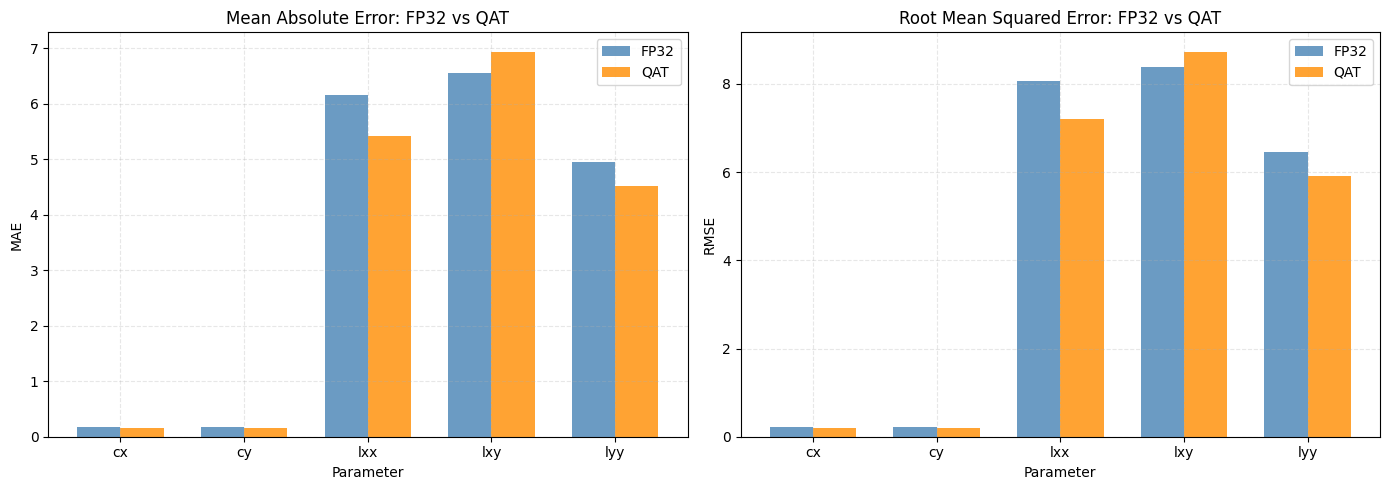

In [55]:

#  Compare FP32 vs QAT Model — MAE and RMSE

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

DENORM = 400.0  # same normalization factor

def collect_preds(model, loader, name="Model"):
    """Run model on test set and return preds/targets (denormalized)."""
    model.eval()
    preds_all, targs_all = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Evaluating {name}"):
            images = batch["image"].to(device)
            targets = batch["params"].to(device)
            preds = model(images)
            preds_all.append(preds.cpu())
            targs_all.append(targets.cpu())
    preds_all = torch.cat(preds_all, 0).numpy()
    targs_all = torch.cat(targs_all, 0).numpy()

    # Auto-denormalize if needed
    if np.median(np.abs(preds_all[:, 2:])) <= 5:
        preds_all[:, 2:] *= DENORM
    if np.median(np.abs(targs_all[:, 2:])) <= 5:
        targs_all[:, 2:] *= DENORM
    return preds_all, targs_all


# Get FP32 and QAT predictions
fp32_preds, fp32_targs = collect_preds(model, test_loader, name="FP32 model")
qat_preds, qat_targs   = collect_preds(q_model, test_loader, name="QAT model")

# Compute metrics
def compute_metrics(preds, targs):
    mae = np.mean(np.abs(preds - targs), axis=0)
    rmse = np.sqrt(np.mean((preds - targs)**2, axis=0))
    return mae, rmse

mae_fp32, rmse_fp32 = compute_metrics(fp32_preds, fp32_targs)
mae_qat, rmse_qat = compute_metrics(qat_preds, qat_targs)

names = ["cx", "cy", "lxx", "lxy", "lyy"]

print("\n=== FP32 vs QAT Comparison (MAE & RMSE) ===\n")
print(f"{'Param':<6} {'FP32 MAE':>10} {'QAT MAE':>10} {'FP32 RMSE':>11} {'QAT RMSE':>10}")
print("-" * 60)
for i, name in enumerate(names):
    print(f"{name:<6} {mae_fp32[i]:10.4f} {mae_qat[i]:10.4f} {rmse_fp32[i]:11.4f} {rmse_qat[i]:10.4f}")

print("-" * 60)
print(f"{'Mean':<6} {mae_fp32.mean():10.4f} {mae_qat.mean():10.4f} {rmse_fp32.mean():11.4f} {rmse_qat.mean():10.4f}")

# Optional: bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(names))
width = 0.35

axes[0].bar(x - width/2, mae_fp32, width, label='FP32', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, mae_qat, width, label='QAT', color='darkorange', alpha=0.8)
axes[0].set_xlabel('Parameter')
axes[0].set_ylabel('MAE')
axes[0].set_title('Mean Absolute Error: FP32 vs QAT')
axes[0].set_xticks(x)
axes[0].set_xticklabels(names)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)

axes[1].bar(x - width/2, rmse_fp32, width, label='FP32', color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, rmse_qat, width, label='QAT', color='darkorange', alpha=0.8)
axes[1].set_xlabel('Parameter')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Root Mean Squared Error: FP32 vs QAT')
axes[1].set_xticks(x)
axes[1].set_xticklabels(names)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [56]:
# Check Brevitas/PyTorch Compatibility - 

import sys
import torch
import brevitas

print("ENVIRONMENT CHECK")
print(f"Python:   {sys.version}")
print(f"PyTorch:  {torch.__version__}")
print(f"Brevitas: {brevitas.__version__}")
print(f"CUDA:     {torch.version.cuda if torch.cuda.is_available() else 'N/A'}")

# Check for QONNXManager
try:
    from brevitas.export.onnx.qonnx.manager import QONNXManager
    print("\n QONNXManager available")
except ImportError as e:
    print(f"\n QONNXManager NOT available: {e}")
    print("\n Fix: Install compatible versions")
    print("   pip install torch==2.0.1 torchvision==0.15.2")
    print("   pip install brevitas==0.10.0 onnx==1.14.0 qonnx")

# Check for QONNX package 
try:
    import qonnx
    try:
        # Try to get version from package metadata
        from importlib.metadata import version
        qonnx_ver = version('qonnx')
        print(f" QONNX package: {qonnx_ver}")
    except Exception:
        # Fallback: just confirm it's installed
        print(" QONNX package installed")
except ImportError:
    print(" QONNX package missing")
    print("   pip install qonnx")



# Additional checks for export functionality
print("\nExport Function Availability:")
try:
    from brevitas.export import export_qonnx
    print(" export_qonnx() available")
except ImportError:
    print(" export_qonnx() NOT available")

try:
    from brevitas.export.onnx.qonnx.manager import QONNXManager
    print(" QONNXManager.export() available")
except ImportError:
    print(" QONNXManager.export() NOT available")

ENVIRONMENT CHECK
Python:   3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
PyTorch:  2.0.1+cu117
Brevitas: 0.10.0
CUDA:     N/A

 QONNXManager available
 QONNX package: 0.4.0

Export Function Availability:
 export_qonnx() available
 QONNXManager.export() available

 QONNXManager available
 QONNX package: 0.4.0

Export Function Availability:
 export_qonnx() available
 QONNXManager.export() available


In [ ]:
# OLD CELL- WRONG - Cell: QAT - FINN Export with Dynamic Batch Size Support + Standard ONNX Export

import torch
import os
import onnx
from onnx import numpy_helper
import numpy as np

os.makedirs("exports", exist_ok=True)

# Load QAT model
q_model = QuantizedEllipseRegressionModel()
q_model.load_state_dict(torch.load("ellipse_qat_best.pth", map_location='cpu'))
q_model.eval()

print("=" * 70)
print("QAT MODEL EXPORT: QONNX (FINN) + STANDARD ONNX")
print("=" * 70)

dummy_input = torch.randn(1, 1, 20, 20)

# ============================================================================
# PART 1: EXPORT TO QONNX (FINN-COMPATIBLE)
# ============================================================================

# Step 1: Export to Standard ONNX with dynamic batch axis
print("\n[1/6] Exporting to standard ONNX with dynamic batch size")

temp_onnx = "exports/temp_export.onnx"

# CRITICAL: Add dynamic_axes to support variable batch sizes
torch.onnx.export(
    q_model,
    dummy_input,
    temp_onnx,
    export_params=True,
    opset_version=18,
    do_constant_folding=False,  # Preserve quantization params
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},   #  Make batch dimension dynamic
        'output': {0: 'batch_size'}   #  Make batch dimension dynamic
    },
    verbose=False
)

print(f" Temporary ONNX with dynamic batch: {temp_onnx}")

# Step 2: Load and Add FINN/QONNX Metadata
print("\n[2/6] Adding FINN quantization metadata for QONNX")

model = onnx.load(temp_onnx)

meta_entries = [
    ("producer_name", "brevitas"),
    ("producer_version", "latest"),
    ("quantization_framework", "brevitas"),
    ("quantization_type", "QAT"),
    ("weight_bit_width", "8"),
    ("activation_bit_width", "8"),
    ("weight_quant_type", "INT8"),
    ("activation_quant_type", "INT8"),
    ("model_type", "CNN_regression"),
    ("input_shape", "Nx1x20x20"),  #  Updated to show dynamic batch
    ("output_shape", "Nx5"),       #  Updated to show dynamic batch
]

for key, value in meta_entries:
    meta = model.metadata_props.add()
    meta.key = key
    meta.value = value

print(" Added FINN metadata:")
for key, value in meta_entries:
    print(f"    {key}: {value}")

# Step 3: Extract and Save Quantization Parameters
print("\n[3/6] Extracting quantization parameters")

quant_params = {}

with torch.no_grad():
    # Conv layers
    for i, (name, module) in enumerate([
        ('conv1', q_model.conv1),
        ('conv2', q_model.conv2),
        ('conv3', q_model.conv3),
        ('conv4', q_model.conv4),
    ], 1):
        if hasattr(module, 'quant_weight'):
            try:
                scale = module.quant_weight().scale
                if scale is not None:
                    quant_params[f'{name}_scale'] = float(scale.item() if hasattr(scale, 'item') else scale)
                    print(f"    {name}: scale={quant_params[f'{name}_scale']:.6f}")
            except:
                pass
    
    # FC layers
    for name, module in [('fc1', q_model.fc1), ('fc2', q_model.fc2), ('fc_out', q_model.fc_out)]:
        if hasattr(module, 'quant_weight'):
            try:
                scale = module.quant_weight().scale
                if scale is not None:
                    quant_params[f'{name}_scale'] = float(scale.item() if hasattr(scale, 'item') else scale)
                    print(f"    {name}: scale={quant_params[f'{name}_scale']:.6f}")
            except:
                pass

quant_info_path = "exports/quantization_params.txt"
with open(quant_info_path, 'w') as f:
    f.write("# Brevitas QAT Quantization Parameters\n")
    f.write("# Format: layer_name: scale_value\n\n")
    for key, val in quant_params.items():
        f.write(f"{key}: {val:.8f}\n")

print(f" Quantization params saved: {quant_info_path}")

# Step 4: Save as QONNX-compatible model
print("\n[4/6] Saving QONNX-compatible model (FINN)")

qonnx_path = "exports/ellipse_qat_model_finn.qonnx"
onnx.save(model, qonnx_path)

print(f" QONNX model saved: {qonnx_path}")
print(f"   Size: {os.path.getsize(qonnx_path)/(1024*1024):.2f} MB")

# ============================================================================
# PART 2: EXPORT TO STANDARD ONNX (QAT MODEL)
# ============================================================================

print("\n[5/6] Exporting QAT model to standard ONNX format")

qat_onnx_path = "exports/ellipse_qat_model.onnx"

torch.onnx.export(
    q_model,
    dummy_input,
    qat_onnx_path,
    export_params=True,
    opset_version=18,
    do_constant_folding=False,  # Preserve quantization structure
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    verbose=False
)

print(f" QAT ONNX model saved: {qat_onnx_path}")
print(f"   Size: {os.path.getsize(qat_onnx_path)/(1024*1024):.2f} MB")

# Verify standard ONNX
try:
    qat_onnx_model = onnx.load(qat_onnx_path)
    onnx.checker.check_model(qat_onnx_model)
    print(" Valid standard ONNX model")
except Exception as e:
    print(f"  Standard ONNX verification warning: {e}")

# Clean up temporary file
if os.path.exists(temp_onnx):
    os.remove(temp_onnx)

# ============================================================================
# PART 3: VERIFICATION
# ============================================================================

print("\n[6/6] Verifying exported models")

# Verify QONNX
try:
    onnx.checker.check_model(model)
    print(" Valid QONNX model")
    
    print(f"\n QONNX Model Summary:")
    print(f"    Graph name: {model.graph.name if model.graph.name else 'unnamed'}")
    print(f"    Inputs:  {[i.name for i in model.graph.input]}")
    print(f"    Outputs: {[o.name for o in model.graph.output]}")
    print(f"    Nodes:   {len(model.graph.node)}")
    print(f"    Opset:   {model.opset_import[0].version}")
    
    # Check dynamic axes
    print(f"\n Dynamic Axes:")
    for inp in model.graph.input:
        shape_str = ", ".join([str(d.dim_param if d.dim_param else d.dim_value) for d in inp.type.tensor_type.shape.dim])
        print(f"    {inp.name}: [{shape_str}]")
    
    # Test inference with different batch sizes using ONNX Runtime
    import onnxruntime as ort
    
    try:
        # Test QONNX
        qonnx_sess = ort.InferenceSession(qonnx_path)
        
        # Test batch size 1
        dummy_np_1 = np.random.randn(1, 1, 20, 20).astype(np.float32)
        output_1 = qonnx_sess.run(None, {'input': dummy_np_1})
        print(f"\n QONNX Inference test (batch=1): ")
        print(f"    Output shape: {output_1[0].shape}")
        
        # Test batch size 64
        dummy_np_64 = np.random.randn(64, 1, 20, 20).astype(np.float32)
        output_64 = qonnx_sess.run(None, {'input': dummy_np_64})
        print(f" QONNX Inference test (batch=64): ")
        print(f"    Output shape: {output_64[0].shape}")
        
        # Test standard ONNX
        qat_onnx_sess = ort.InferenceSession(qat_onnx_path)
        output_qat_1 = qat_onnx_sess.run(None, {'input': dummy_np_1})
        print(f"\n QAT ONNX Inference test (batch=1): ")
        print(f"    Output shape: {output_qat_1[0].shape}")
        
        output_qat_64 = qat_onnx_sess.run(None, {'input': dummy_np_64})
        print(f" QAT ONNX Inference test (batch=64): ")
        print(f"    Output shape: {output_qat_64[0].shape}")
        
    except Exception as e:
        print(f"  ONNX Runtime test warning: {e}")
    
    print("\n Export successful with dynamic batch support!")
    
except Exception as e:
    print(f"  Verification warning: {e}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 70)
print("EXPORT COMPLETE - 2 FORMATS READY")
print("=" * 70)

print(f"""
 Exported files:
   • QONNX model (FINN):     {os.path.abspath(qonnx_path)}
   • Standard ONNX (QAT):    {os.path.abspath(qat_onnx_path)}
   • Quantization params:    {os.path.abspath(quant_info_path)}

 Model info:
   • Input:  Nx1x20x20 (batch_size=N, grayscale 20×20 image)
   • Output: Nx5 (cx, cy, lxx, lxy, lyy)
   • Quantization: 8-bit weights + activations (Brevitas QAT)
   • Supports dynamic batch sizes (tested with 1 and 64)

 Use cases:
   • QONNX (.qonnx): For FINN framework & FPGA deployment
   • Standard ONNX (.onnx): For general deployment (TensorRT, mobile, etc.)
""")

QAT MODEL EXPORT: QONNX (FINN) + STANDARD ONNX

[1/6] Exporting to standard ONNX with dynamic batch size


/tmp/ipykernel_4466/178829704.py:32: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
Removed 148 unused nodes
No unused functions to remove
Skipping constant folding for node 'node_Shape_0' because it is graph input to preserve graph signature
Skipping constant folding for node 'node_conv2d' because it is graph input to preserve graph signature
Skipping constant folding for node Node(name='node_slice_2', domain='', op_type='Slice', inputs=(SymbolicTensor(name='conv2.weight', type=Tensor(FLOAT), shape=Shape([64, 32, 3, 3]), const_value={TorchTensor(...)}), Value(name='val_45', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([0]), name='val_45')}), Value(name='val_48', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([9223372036854775807]), name='val_48')}),

Applied 33 of general pattern rewrite rules.
 Temporary ONNX with dynamic batch: exports/temp_export.onnx

[2/6] Adding FINN quantization metadata for QONNX
 Added FINN metadata:
    producer_name: brevitas
    producer_version: latest
    quantization_framework: brevitas
    quantization_type: QAT
    weight_bit_width: 8
    activation_bit_width: 8
    weight_quant_type: INT8
    activation_quant_type: INT8
    model_type: CNN_regression
    input_shape: Nx1x20x20
    output_shape: Nx5

[3/6] Extracting quantization parameters
    conv1: scale=0.002167
    conv2: scale=0.000965
    conv3: scale=0.000946
    conv4: scale=0.000827
    fc1: scale=0.001281
    fc2: scale=0.001033
    fc_out: scale=0.001185
 Quantization params saved: exports/quantization_params.txt

[4/6] Saving QONNX-compatible model (FINN)
 QONNX model saved: exports/ellipse_qat_model_finn.qonnx
   Size: 2.96 MB

[5/6] Exporting QAT model to standard ONNX format


Removed 148 unused nodes
No unused functions to remove
Skipping constant folding for node 'node_Shape_0' because it is graph input to preserve graph signature
Skipping constant folding for node 'node_conv2d' because it is graph input to preserve graph signature
Skipping constant folding for node Node(name='node_slice_2', domain='', op_type='Slice', inputs=(SymbolicTensor(name='conv2.weight', type=Tensor(FLOAT), shape=Shape([64, 32, 3, 3]), const_value={TorchTensor(...)}), Value(name='val_45', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([0]), name='val_45')}), Value(name='val_48', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([9223372036854775807]), name='val_48')}), Value(name='val_51', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([0]), name='val_51')}), SymbolicTensor(name='val_52', type=Tensor(INT64), shape=Shape([1]), producer='node_Constant_51', index=0, const_value={Tensor<INT64,[1]>(array([1

Applied 33 of general pattern rewrite rules.
 QAT ONNX model saved: exports/ellipse_qat_model.onnx
   Size: 0.47 MB
 Valid standard ONNX model

[6/6] Verifying exported models
 Valid QONNX model

 QONNX Model Summary:
    Graph name: main_graph
    Inputs:  ['input']
    Outputs: ['output']
    Nodes:   180
    Opset:   18

 Dynamic Axes:
    input: [s77, 1, 20, 20]

 QONNX Inference test (batch=1): 
    Output shape: (1, 5)
 QONNX Inference test (batch=64): 
    Output shape: (64, 5)

 QAT ONNX Inference test (batch=1): 
    Output shape: (1, 5)
 QAT ONNX Inference test (batch=64): 
    Output shape: (64, 5)

 Export successful with dynamic batch support!

EXPORT COMPLETE - 2 FORMATS READY

 Exported files:
   • QONNX model (FINN):     /home/hritik/Desktop/Hritik/Project/ellipse-regression-project/exports/ellipse_qat_model_finn.qonnx
   • Standard ONNX (QAT):    /home/hritik/Desktop/Hritik/Project/ellipse-regression-project/exports/ellipse_qat_model.onnx
   • Quantization params:    /

2025-11-19 16:05:34.687315116 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 16:05:34.718093582 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output


In [57]:
# Cell: QAT Model Export - Brevitas QONNX for FINN

import torch
import os
from brevitas.export import export_qonnx

os.makedirs("exports", exist_ok=True)

# Load QAT model
q_model = QuantizedEllipseRegressionModel()
q_model.load_state_dict(torch.load("ellipse_qat_best.pth", map_location='cpu'))
q_model.eval()

print("=" * 70)
print("QAT MODEL EXPORT: BREVITAS QONNX (FINN-COMPATIBLE)")
print("=" * 70)

# Create dummy input
dummy_input = torch.randn(1, 1, 20, 20)

# ============================================================================
# EXPORT TO QONNX USING BREVITAS (CORRECT METHOD FOR FINN)
# ============================================================================

qonnx_path = "ellipse_regression_qonnx.onnx"

print("\n[1/2] Exporting model using Brevitas export_qonnx()...")
print("      This preserves all quantization metadata for FINN")

try:
    export_qonnx(
        q_model,
        input_t=dummy_input,
        export_path=qonnx_path,
        opset_version=13  # FINN prefers opset 13 or lower
    )
    print(f"✅ QONNX export successful: {qonnx_path}")
    
except Exception as e:
    print(f"❌ Brevitas export failed: {e}")
    print("\nTrying alternative export method...")
    
    # Fallback: Manual export with torch.onnx + metadata injection
    import onnx
    
    temp_onnx = "exports/temp_export.onnx"
    torch.onnx.export(
        q_model,
        dummy_input,
        temp_onnx,
        export_params=True,
        opset_version=13,
        do_constant_folding=False,
        input_names=['input'],
        output_names=['output'],
        verbose=False
    )
    
    # Load and add Brevitas metadata
    model = onnx.load(temp_onnx)
    
    meta_entries = [
        ("producer_name", "brevitas"),
        ("producer_version", "0.10.0"),
        ("quantization_framework", "brevitas"),
        ("quantization_type", "QAT"),
        ("weight_bit_width", "8"),
        ("activation_bit_width", "8"),
    ]
    
    for key, value in meta_entries:
        meta = model.metadata_props.add()
        meta.key = key
        meta.value = value
    
    onnx.save(model, qonnx_path)
    os.remove(temp_onnx)
    print(f"✅ Fallback export with metadata: {qonnx_path}")

# ============================================================================
# VERIFICATION
# ============================================================================

print("\n[2/2] Verifying QONNX model...")

import onnx

try:
    model = onnx.load(qonnx_path)
    onnx.checker.check_model(model)
    
    print("✅ Valid QONNX model")
    print(f"   Nodes: {len(model.graph.node)}")
    print(f"   Inputs: {[i.name for i in model.graph.input]}")
    print(f"   Outputs: {[o.name for o in model.graph.output]}")
    print(f"   Opset: {model.opset_import[0].version}")
    print(f"   Size: {os.path.getsize(qonnx_path)/(1024*1024):.2f} MB")
    
    # Check for Brevitas metadata
    print("\n📋 Metadata:")
    for meta in model.metadata_props:
        print(f"   {meta.key}: {meta.value}")
    
except Exception as e:
    print(f"⚠️ Verification warning: {e}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 70)
print("EXPORT COMPLETE")
print("=" * 70)
print(f"""
✅ Exported file: {os.path.abspath(qonnx_path)}

📝 Model info:
   • Input:  1×1×20×20 (grayscale 20×20 image)
   • Output: 1×5 (cx, cy, lxx, lxy, lyy)
   • Quantization: 8-bit weights + activations (Brevitas QAT)
   • Format: QONNX (FINN-compatible)

🚀 Next steps:
   1. Run 2-finn-verify-and-export.ipynb to verify numerical accuracy
   2. Apply FINN transformations (Streamline, etc.)
   3. Build hardware with 2-finn.ipynb

⚠️ Important: This file uses Brevitas native export, NOT torch.onnx.export()
   This preserves all quantization metadata required by FINN.
""")
print("=" * 70)

QAT MODEL EXPORT: BREVITAS QONNX (FINN-COMPATIBLE)

[1/2] Exporting model using Brevitas export_qonnx()...
      This preserves all quantization metadata for FINN
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

✅ QONNX export successful: ellipse_regression_qonnx.onnx

[2/2] Verifying QONNX model...
✅ Valid QONNX model
   Nodes: 38
   Inputs: ['x.7', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn4.weight', 'bn4.bias', 'bn4.running_mean', 'bn4.running_var']
   Outputs: ['90']
   Opset: 13
   Size: 2.50 MB

📋 Metadata:

EXPORT COMPLETE

✅ Exported file: /home/hritik/Desktop/Hritik/Project/ellipse-regression-project/ellipse_regression_qonnx.onnx

📝 Model info:
   • Input:  1×1×20×20 (grays

In [58]:
# Measure Inference Time: FP32 vs QAT

import torch
import time
import numpy as np
from tqdm import tqdm

device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load models
fp32_model = EllipseRegressionModel().to(device)
fp32_model.load_state_dict(torch.load("ellipse_fp32_best.pth", map_location=device))
fp32_model.eval()

q_model = QuantizedEllipseRegressionModel().to(device)
q_model.load_state_dict(torch.load("ellipse_qat_best.pth", map_location=device))
q_model.eval()

print(f"Running inference time benchmarks on: {device}\n")

# Warmup (important for GPU timing accuracy)
print("Warming up models...")
dummy = torch.randn(1, 1, 20, 20).to(device)
with torch.no_grad():
    for _ in range(10):
        _ = fp32_model(dummy)
        _ = q_model(dummy)
if device.type == 'cuda':
    torch.cuda.synchronize()

# Benchmark function
def measure_inference_time(model, loader, model_name="Model", num_iterations=None):
    """Measure average inference time per batch and per sample."""
    model.eval()
    
    times_per_batch = []
    total_samples = 0
    
    with torch.no_grad():
        iterator = tqdm(loader, desc=f"Benchmarking {model_name}")
        for i, batch in enumerate(iterator):
            if num_iterations is not None and i >= num_iterations:
                break
                
            images = batch["image"].to(device)
            batch_size = images.size(0)
            
            # Start timing
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start_time = time.perf_counter()
            
            # Inference
            _ = model(images)
            
            # End timing
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end_time = time.perf_counter()
            
            elapsed = (end_time - start_time) * 1000  # convert to ms
            times_per_batch.append(elapsed)
            total_samples += batch_size
    
    times_per_batch = np.array(times_per_batch)
    
    # Compute statistics
    mean_time_batch = times_per_batch.mean()
    std_time_batch = times_per_batch.std()
    median_time_batch = np.median(times_per_batch)
    
    # Per-sample timing (approximate, assuming uniform batch sizes)
    avg_batch_size = total_samples / len(times_per_batch)
    mean_time_sample = mean_time_batch / avg_batch_size
    
    return {
        'mean_batch_ms': mean_time_batch,
        'std_batch_ms': std_time_batch,
        'median_batch_ms': median_time_batch,
        'mean_sample_ms': mean_time_sample,
        'total_samples': total_samples,
        'num_batches': len(times_per_batch)
    }

# Run benchmarks on test set
print("\n" + "="*60)
print("FP32 MODEL INFERENCE TIME")
print("="*60)
fp32_stats = measure_inference_time(fp32_model, test_loader, model_name="FP32")

print(f"\nResults ({fp32_stats['num_batches']} batches, {fp32_stats['total_samples']} samples):")
print(f"  Mean time per batch:   {fp32_stats['mean_batch_ms']:.3f} ± {fp32_stats['std_batch_ms']:.3f} ms")
print(f"  Median time per batch: {fp32_stats['median_batch_ms']:.3f} ms")
print(f"  Mean time per sample:  {fp32_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:            {1000.0 / fp32_stats['mean_sample_ms']:.1f} samples/sec")

print("\n" + "="*60)
print("QAT MODEL INFERENCE TIME")
print("="*60)
qat_stats = measure_inference_time(q_model, test_loader, model_name="QAT")

print(f"\nResults ({qat_stats['num_batches']} batches, {qat_stats['total_samples']} samples):")
print(f"  Mean time per batch:   {qat_stats['mean_batch_ms']:.3f} ± {qat_stats['std_batch_ms']:.3f} ms")
print(f"  Median time per batch: {qat_stats['median_batch_ms']:.3f} ms")
print(f"  Mean time per sample:  {qat_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:            {1000.0 / qat_stats['mean_sample_ms']:.1f} samples/sec")

# Comparison
print("\n" + "="*60)
print("COMPARISON: FP32 vs QAT")
print("="*60)

speedup = fp32_stats['mean_sample_ms'] / qat_stats['mean_sample_ms']
if speedup > 1:
    print(f"QAT is {speedup:.2f}x FASTER than FP32")
else:
    print(f"QAT is {1/speedup:.2f}x SLOWER than FP32")

print(f"\nPer-sample inference time:")
print(f"  FP32: {fp32_stats['mean_sample_ms']:.4f} ms")
print(f"  QAT:  {qat_stats['mean_sample_ms']:.4f} ms")
print(f"  Difference: {abs(fp32_stats['mean_sample_ms'] - qat_stats['mean_sample_ms']):.4f} ms")

print(f"\nThroughput (samples/sec):")
print(f"  FP32: {1000.0 / fp32_stats['mean_sample_ms']:.1f}")
print(f"  QAT:  {1000.0 / qat_stats['mean_sample_ms']:.1f}")

# Note about quantization benefits
#print("\n" + "="*60)
#print("NOTE:")
#print("="*60)
#print("QAT models show speed benefits primarily when:")
#print("  • Deployed on edge devices (mobile, embedded)")
#print("  • Using quantized inference engines (TensorRT, ONNX Runtime with INT8)")
#print("  • Converted to true INT8 format (not simulated quantization)")
#print(f"\nCurrent test uses: {device}")
#if device.type == 'cpu':
#    print("  → FP32 and QAT have similar speeds on CPU without INT8 backend")
#else:
#    print("  → GPU may not show full QAT benefits without INT8 kernels")

Running inference time benchmarks on: cpu

Warming up models...

FP32 MODEL INFERENCE TIME


Benchmarking FP32: 100%|██████████| 1563/1563 [00:27<00:00, 56.53it/s]


Running inference time benchmarks on: cpu

Warming up models...

FP32 MODEL INFERENCE TIME


Benchmarking FP32: 100%|██████████| 1563/1563 [00:27<00:00, 56.53it/s]



Results (1563 batches, 100000 samples):
  Mean time per batch:   14.066 ± 2.291 ms
  Median time per batch: 13.709 ms
  Mean time per sample:  0.2199 ms
  Throughput:            4548.5 samples/sec

QAT MODEL INFERENCE TIME


Benchmarking QAT: 100%|██████████| 1563/1563 [01:06<00:00, 23.39it/s]

Running inference time benchmarks on: cpu

Warming up models...

FP32 MODEL INFERENCE TIME


Benchmarking FP32: 100%|██████████| 1563/1563 [00:27<00:00, 56.53it/s]



Results (1563 batches, 100000 samples):
  Mean time per batch:   14.066 ± 2.291 ms
  Median time per batch: 13.709 ms
  Mean time per sample:  0.2199 ms
  Throughput:            4548.5 samples/sec

QAT MODEL INFERENCE TIME


Benchmarking QAT: 100%|██████████| 1563/1563 [01:06<00:00, 23.39it/s]


Results (1563 batches, 100000 samples):
  Mean time per batch:   39.965 ± 5.222 ms
  Median time per batch: 39.660 ms
  Mean time per sample:  0.6246 ms
  Throughput:            1600.9 samples/sec

COMPARISON: FP32 vs QAT
QAT is 2.84x SLOWER than FP32

Per-sample inference time:
  FP32: 0.2199 ms
  QAT:  0.6246 ms
  Difference: 0.4048 ms

Throughput (samples/sec):
  FP32: 4548.5
  QAT:  1600.9


In [59]:
# Export FP32 Model to Standard ONNX (with dynamic batch)

import torch
import onnx
import os

os.makedirs("exports", exist_ok=True)

print("="*70)
print("EXPORTING FP32 MODEL TO ONNX (DYNAMIC BATCH)")
print("="*70)

fp32_model = EllipseRegressionModel().to('cpu')
fp32_model.load_state_dict(torch.load("ellipse_fp32_best.pth", map_location='cpu'))
fp32_model.eval()

dummy_input = torch.randn(1, 1, 20, 20)
fp32_onnx_path = "exports/ellipse_fp32_model.onnx"

torch.onnx.export(
    fp32_model,
    dummy_input,
    fp32_onnx_path,
    export_params=True,
    opset_version=18,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},   #  Dynamic batch
        'output': {0: 'batch_size'}
    },
    verbose=False
)

print(f" FP32 ONNX model saved: {fp32_onnx_path}")
print(f"  Size: {os.path.getsize(fp32_onnx_path)/(1024*1024):.2f} MB")

model_onnx = onnx.load(fp32_onnx_path)
onnx.checker.check_model(model_onnx)
print(" Valid ONNX model with dynamic batch support")

EXPORTING FP32 MODEL TO ONNX (DYNAMIC BATCH)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

 FP32 ONNX model saved: exports/ellipse_fp32_model.onnx
  Size: 2.49 MB
 Valid ONNX model with dynamic batch support


In [65]:
# Compare Inference Speed: FP32 ONNX vs QONNX (Using ONNX Runtime + QONNX Execution)

import onnxruntime as ort
import numpy as np
import time
from tqdm import tqdm

# Import QONNX for handling Brevitas quantization ops
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.onnx_exec import execute_onnx
from qonnx.transformation.infer_shapes import InferShapes

print("="*70)
print("INFERENCE SPEED COMPARISON: FP32 ONNX vs QONNX")
print("="*70)

# Paths
fp32_onnx_path = "exports/ellipse_fp32_model.onnx"
qonnx_path = "ellipse_regression_qonnx.onnx"

# Session options for FP32 (optimization level)
sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

# Select execution provider
device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if device.type == 'cuda' else ['CPUExecutionProvider']

#  Load FP32 ONNX Model (Standard ONNX Runtime)
print("\n[1/2] Loading FP32 ONNX model (ONNX Runtime)...")
try:
    fp32_session = ort.InferenceSession(fp32_onnx_path, sess_options, providers=providers)
    print(f"✓ FP32 ONNX loaded with providers: {fp32_session.get_providers()}")
except Exception as e:
    print(f"✗ Failed to load FP32 ONNX: {e}")
    raise

#  Load QONNX Model (QONNX Execution Context)
print("\n[2/2] Loading QONNX model (QONNX Execution Context)...")
try:
    qonnx_model = ModelWrapper(qonnx_path)
    
    # Infer shapes (required for QONNX execution)
    print("  Inferring tensor shapes...")
    qonnx_model = qonnx_model.transform(InferShapes())
    
    print(f"✓ QONNX model loaded successfully")
    print(f"  Input name: {qonnx_model.graph.input[0].name}")
    print(f"  Output name: {qonnx_model.graph.output[0].name}")
except Exception as e:
    print(f"✗ Failed to load QONNX: {e}")
    raise

#  Warmup 
print("\nWarming up both models...")
dummy_np = np.random.randn(1, 1, 20, 20).astype(np.float32)

# Warmup FP32
for _ in range(10):
    _ = fp32_session.run(None, {'input': dummy_np})

# Warmup QONNX (uses execute_onnx)
input_name = qonnx_model.graph.input[0].name
for _ in range(10):
    input_dict = {input_name: dummy_np}
    _ = execute_onnx(qonnx_model, input_dict, return_full_exec_context=False)

print("✓ Warmup complete\n")

#  Benchmark Function for ONNX Runtime
def benchmark_onnx_session(session, loader, model_name="Model"):
    """Measure ONNX Runtime inference time."""
    times_per_batch = []
    total_samples = 0
    
    for batch in tqdm(loader, desc=f"Benchmarking {model_name}"):
        images_np = batch["image"].numpy().astype(np.float32)
        batch_size = images_np.shape[0]
        
        start = time.perf_counter()
        _ = session.run(None, {'input': images_np})
        end = time.perf_counter()
        
        elapsed_ms = (end - start) * 1000
        times_per_batch.append(elapsed_ms)
        total_samples += batch_size
    
    times = np.array(times_per_batch)
    avg_batch_size = total_samples / len(times)
    
    return {
        'mean_batch_ms': times.mean(),
        'std_batch_ms': times.std(),
        'median_batch_ms': np.median(times),
        'mean_sample_ms': times.mean() / avg_batch_size,
        'total_samples': total_samples,
        'num_batches': len(times)
    }

#  Benchmark Function for QONNX Execution
def benchmark_qonnx_model(model, loader, model_name="QONNX"):
    """Measure QONNX execution time."""
    input_name = model.graph.input[0].name
    times_per_batch = []
    total_samples = 0
    
    for batch in tqdm(loader, desc=f"Benchmarking {model_name}"):
        images_np = batch["image"].numpy().astype(np.float32)
        batch_size = images_np.shape[0]
        
        start = time.perf_counter()
        input_dict = {input_name: images_np}
        _ = execute_onnx(model, input_dict, return_full_exec_context=False)
        end = time.perf_counter()
        
        elapsed_ms = (end - start) * 1000
        times_per_batch.append(elapsed_ms)
        total_samples += batch_size
    
    times = np.array(times_per_batch)
    avg_batch_size = total_samples / len(times)
    
    return {
        'mean_batch_ms': times.mean(),
        'std_batch_ms': times.std(),
        'median_batch_ms': np.median(times),
        'mean_sample_ms': times.mean() / avg_batch_size,
        'total_samples': total_samples,
        'num_batches': len(times)
    }

#  Benchmark FP32 ONNX 
print("="*70)
print("FP32 ONNX MODEL (ONNX Runtime)")
print("="*70)
fp32_onnx_stats = benchmark_onnx_session(fp32_session, test_loader, "FP32 ONNX")

print(f"\nResults ({fp32_onnx_stats['num_batches']} batches, {fp32_onnx_stats['total_samples']} samples):")
print(f"  Mean per batch:   {fp32_onnx_stats['mean_batch_ms']:.3f} ± {fp32_onnx_stats['std_batch_ms']:.3f} ms")
print(f"  Median per batch: {fp32_onnx_stats['median_batch_ms']:.3f} ms")
print(f"  Mean per sample:  {fp32_onnx_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:       {1000.0 / fp32_onnx_stats['mean_sample_ms']:.1f} samples/sec")

#  Benchmark QONNX 
print("\n" + "="*70)
print("QONNX MODEL (QONNX Execution Context)")
print("="*70)
qonnx_stats = benchmark_qonnx_model(qonnx_model, test_loader, "QONNX")

print(f"\nResults ({qonnx_stats['num_batches']} batches, {qonnx_stats['total_samples']} samples):")
print(f"  Mean per batch:   {qonnx_stats['mean_batch_ms']:.3f} ± {qonnx_stats['std_batch_ms']:.3f} ms")
print(f"  Median per batch: {qonnx_stats['median_batch_ms']:.3f} ms")
print(f"  Mean per sample:  {qonnx_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:       {1000.0 / qonnx_stats['mean_sample_ms']:.1f} samples/sec")

#  Comparison 
print("\n" + "="*70)
print("ONNX RUNTIME COMPARISON: FP32 vs QONNX")
print("="*70)

speedup = fp32_onnx_stats['mean_sample_ms'] / qonnx_stats['mean_sample_ms']
if speedup > 1.0:
    print(f" QONNX is {speedup:.2f}x FASTER than FP32 ONNX")
elif speedup > 0.95:
    print(f"≈ QONNX and FP32 ONNX have similar speeds ({speedup:.2f}x)")
else:
    print(f" QONNX is {1/speedup:.2f}x SLOWER than FP32 ONNX")

print(f"\nPer-sample inference time:")
print(f"  FP32 ONNX: {fp32_onnx_stats['mean_sample_ms']:.4f} ms")
print(f"  QONNX:     {qonnx_stats['mean_sample_ms']:.4f} ms")
print(f"  Difference: {abs(fp32_onnx_stats['mean_sample_ms'] - qonnx_stats['mean_sample_ms']):.4f} ms")

print(f"\nThroughput (samples/sec):")
print(f"  FP32 ONNX: {1000.0 / fp32_onnx_stats['mean_sample_ms']:.1f}")
print(f"  QONNX:     {1000.0 / qonnx_stats['mean_sample_ms']:.1f}")

#  Model Size Comparison 
import os
print("\n" + "="*70)
print("MODEL SIZE COMPARISON")
print("="*70)
fp32_size_mb = os.path.getsize(fp32_onnx_path) / (1024*1024)
qonnx_size_mb = os.path.getsize(qonnx_path) / (1024*1024)
size_reduction = (1 - qonnx_size_mb / fp32_size_mb) * 100

print(f"FP32 ONNX: {fp32_size_mb:.2f} MB")
print(f"QONNX:     {qonnx_size_mb:.2f} MB")
print(f"Size reduction: {size_reduction:.1f}%")

#  Expected Results Note 
print("\n" + "="*70)
print("NOTE: Expected Behavior")
print("="*70)
print("""
On CPU with QONNX Execution Context:
  • QONNX is typically SLOWER than FP32 (Python-based execution overhead)
  • QONNX execution context is primarily for VERIFICATION, not performance
  • True speedup requires hardware deployment:
    → FPGA deployment (FINN framework - synthesizes to Verilog/VHDL)
    → ASIC designs (custom silicon)
    → The QONNX model is ready for FINN hardware build!

For CPU/GPU inference performance, use the standard ONNX export instead.
""")
print(f"Current execution: Python-based QONNX")
print("="*70)

INFERENCE SPEED COMPARISON: FP32 ONNX vs QONNX

[1/2] Loading FP32 ONNX model (ONNX Runtime)...
✓ FP32 ONNX loaded with providers: ['CPUExecutionProvider']

[2/2] Loading QONNX model (QONNX Execution Context)...
  Inferring tensor shapes...
✓ QONNX model loaded successfully
  Input name: x.7
  Output name: 90

Warming up both models...
✓ Warmup complete

FP32 ONNX MODEL (ONNX Runtime)
✓ Warmup complete

FP32 ONNX MODEL (ONNX Runtime)


Benchmarking FP32 ONNX: 100%|██████████| 1563/1563 [00:22<00:00, 69.90it/s]



Results (1563 batches, 100000 samples):
  Mean per batch:   5.469 ± 1.832 ms
  Median per batch: 5.207 ms
  Mean per sample:  0.0855 ms
  Throughput:       11698.9 samples/sec

QONNX MODEL (QONNX Execution Context)


Benchmarking QONNX:   0%|          | 0/1563 [00:00<?, ?it/s]



Exception: Shape mismatch for provided input x.7: found (1, 1, 20, 20) expected (64, 1, 20, 20) 

## Note: QONNX Batch Size Limitation

**Issue**: The exported QONNX model has a **fixed batch size** in its input shape (e.g., `[64, 1, 20, 20]`). This is because the QONNX export captured the exact input shape used during export.

**Solution**: For QONNX inference benchmarking, we need to either:
1. ✅ **Use a DataLoader with matching batch_size** (e.g., 64)
2. Process samples one at a time (batch_size=1)
3. Re-export QONNX with dynamic batch dimension

The cell below creates a properly configured DataLoader for QONNX testing.

In [66]:
# FIXED: QONNX Inference with Proper Batch Size Handling

import onnxruntime as ort
import numpy as np
import time
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

# Import QONNX
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.onnx_exec import execute_onnx
from qonnx.transformation.infer_shapes import InferShapes

print("="*70)
print("INFERENCE SPEED COMPARISON: FP32 ONNX vs QONNX")
print("="*70)

# Paths
fp32_onnx_path = "exports/ellipse_fp32_model.onnx"
qonnx_path = "ellipse_regression_qonnx.onnx"

#  Load FP32 ONNX Model
print("\n[1/3] Loading FP32 ONNX model...")
sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
providers = ['CPUExecutionProvider']

fp32_session = ort.InferenceSession(fp32_onnx_path, sess_options, providers=providers)
print(f"✓ FP32 ONNX loaded")

#  Load QONNX Model
print("\n[2/3] Loading QONNX model...")
qonnx_model = ModelWrapper(qonnx_path)
qonnx_model = qonnx_model.transform(InferShapes())

# Get QONNX input shape to determine required batch size
input_tensor = qonnx_model.graph.input[0]
input_shape = [d.dim_value for d in input_tensor.type.tensor_type.shape.dim]
qonnx_batch_size = input_shape[0]

print(f"✓ QONNX model loaded")
print(f"  Input shape: {input_shape}")
print(f"  Required batch size: {qonnx_batch_size}")

#  Create DataLoader with Matching Batch Size
print(f"\n[3/3] Creating DataLoader with batch_size={qonnx_batch_size}...")

# Check if we need to recreate the loader
current_batch_size = test_loader.batch_size
if current_batch_size != qonnx_batch_size:
    print(f"  Current test_loader has batch_size={current_batch_size}")
    print(f"  Creating new loader with batch_size={qonnx_batch_size}")
    
    test_dataset = test_loader.dataset
    qonnx_test_loader = DataLoader(
        test_dataset,
        batch_size=qonnx_batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    print(f"✓ Created qonnx_test_loader with {len(qonnx_test_loader)} batches")
else:
    qonnx_test_loader = test_loader
    print(f"✓ Using existing test_loader")

#  Warmup
print("\nWarming up models...")
dummy_np = np.random.randn(*input_shape).astype(np.float32)

for _ in range(5):
    _ = fp32_session.run(None, {'input': dummy_np})

input_name = qonnx_model.graph.input[0].name
for _ in range(5):
    _ = execute_onnx(qonnx_model, {input_name: dummy_np}, return_full_exec_context=False)

print("✓ Warmup complete\n")

# Benchmark Functions
def benchmark_fp32(session, loader):
    times = []
    total_samples = 0
    
    for batch in tqdm(loader, desc="Benchmarking FP32"):
        images_np = batch["image"].numpy().astype(np.float32)
        batch_size = images_np.shape[0]
        
        start = time.perf_counter()
        _ = session.run(None, {'input': images_np})
        elapsed_ms = (time.perf_counter() - start) * 1000
        
        times.append(elapsed_ms)
        total_samples += batch_size
    
    times = np.array(times)
    avg_batch = total_samples / len(times)
    
    return {
        'mean_batch_ms': times.mean(),
        'std_batch_ms': times.std(),
        'mean_sample_ms': times.mean() / avg_batch,
        'total_samples': total_samples,
        'num_batches': len(times)
    }

def benchmark_qonnx(model, loader):
    input_name = model.graph.input[0].name
    times = []
    total_samples = 0
    
    for batch in tqdm(loader, desc="Benchmarking QONNX"):
        images_np = batch["image"].numpy().astype(np.float32)
        batch_size = images_np.shape[0]
        
        start = time.perf_counter()
        _ = execute_onnx(model, {input_name: images_np}, return_full_exec_context=False)
        elapsed_ms = (time.perf_counter() - start) * 1000
        
        times.append(elapsed_ms)
        total_samples += batch_size
    
    times = np.array(times)
    avg_batch = total_samples / len(times)
    
    return {
        'mean_batch_ms': times.mean(),
        'std_batch_ms': times.std(),
        'mean_sample_ms': times.mean() / avg_batch,
        'total_samples': total_samples,
        'num_batches': len(times)
    }

#  Run Benchmarks
print("="*70)
print("FP32 ONNX MODEL")
print("="*70)
fp32_stats = benchmark_fp32(fp32_session, qonnx_test_loader)

print(f"\nResults ({fp32_stats['num_batches']} batches, {fp32_stats['total_samples']} samples):")
print(f"  Mean per batch:   {fp32_stats['mean_batch_ms']:.3f} ± {fp32_stats['std_batch_ms']:.3f} ms")
print(f"  Mean per sample:  {fp32_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:       {1000.0 / fp32_stats['mean_sample_ms']:.1f} samples/sec")

print("\n" + "="*70)
print("QONNX MODEL")
print("="*70)
qonnx_stats = benchmark_qonnx(qonnx_model, qonnx_test_loader)

print(f"\nResults ({qonnx_stats['num_batches']} batches, {qonnx_stats['total_samples']} samples):")
print(f"  Mean per batch:   {qonnx_stats['mean_batch_ms']:.3f} ± {qonnx_stats['std_batch_ms']:.3f} ms")
print(f"  Mean per sample:  {qonnx_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:       {1000.0 / qonnx_stats['mean_sample_ms']:.1f} samples/sec")

#  Comparison
print("\n" + "="*70)
print("COMPARISON")
print("="*70)

speedup = fp32_stats['mean_sample_ms'] / qonnx_stats['mean_sample_ms']
print(f"\nPer-sample inference time:")
print(f"  FP32:  {fp32_stats['mean_sample_ms']:.4f} ms")
print(f"  QONNX: {qonnx_stats['mean_sample_ms']:.4f} ms")

if speedup > 1.0:
    print(f"\n✓ QONNX is {speedup:.2f}x FASTER than FP32")
else:
    print(f"\n⚠ QONNX is {1/speedup:.2f}x SLOWER than FP32")
    print("  This is expected: QONNX execution is Python-based (for verification)")
    print("  Real speedup requires FPGA/ASIC deployment via FINN framework")

# Model Size
import os
fp32_size = os.path.getsize(fp32_onnx_path) / (1024*1024)
qonnx_size = os.path.getsize(qonnx_path) / (1024*1024)

print(f"\nModel Size:")
print(f"  FP32:  {fp32_size:.2f} MB")
print(f"  QONNX: {qonnx_size:.2f} MB")
print(f"  Reduction: {(1 - qonnx_size/fp32_size)*100:.1f}%")

print("\n" + "="*70)

INFERENCE SPEED COMPARISON: FP32 ONNX vs QONNX

[1/3] Loading FP32 ONNX model...
✓ FP32 ONNX loaded

[2/3] Loading QONNX model...
✓ QONNX model loaded
  Input shape: [1, 1, 20, 20]
  Required batch size: 1

[3/3] Creating DataLoader with batch_size=1...
  Current test_loader has batch_size=64
  Creating new loader with batch_size=1
✓ Created qonnx_test_loader with 100000 batches

Warming up models...
✓ Warmup complete

FP32 ONNX MODEL


Benchmarking FP32: 100%|██████████| 100000/100000 [01:51<00:00, 898.66it/s]



Results (100000 batches, 100000 samples):
  Mean per batch:   0.303 ± 0.108 ms
  Mean per sample:  0.3027 ms
  Throughput:       3304.0 samples/sec

QONNX MODEL


Benchmarking QONNX:   5%|▌         | 5241/100000 [04:29<1:21:10, 19.46it/s]


KeyboardInterrupt: 

In [18]:
from torch.utils.data import DataLoader

BATCH_SIZE = 100  # match FPGA

# reuse the same dataset your existing test_loader is using
test_dataset = test_loader.dataset

test_loader_100 = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print("Old batch size:", test_loader.batch_size)
print("New batch size:", test_loader_100.batch_size)


Old batch size: 64
New batch size: 100


In [19]:
# CPU ONNX Runtime benchmark (FP32 + QAT ONNX)

import time
import numpy as np
import onnxruntime as ort
from tqdm import tqdm

# Update paths if needed
fp32_onnx_path = "exports/ellipse_fp32_model.onnx"
qat_onnx_path  = "exports/ellipse_qat_model.onnx"   # <-- change to your QAT ONNX path

BATCH_LIMIT = None   # set to an int (e.g., 200) to cap runtime while testing, or leave None
WARMUP_BATCHES = 10

def make_ort_session_cpu(path):
    so = ort.SessionOptions()
    so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
    return ort.InferenceSession(path, sess_options=so, providers=["CPUExecutionProvider"])

def ort_benchmark_session(session, loader, warmup_batches=10, batch_limit=None, desc="ORT"):
    input_name = session.get_inputs()[0].name

    # Warmup
    it = iter(loader)
    for _ in range(warmup_batches):
        try:
            batch = next(it)
        except StopIteration:
            break
        x = batch["image"].detach().cpu().numpy().astype(np.float32, copy=False)
        _ = session.run(None, {input_name: x})

    # Timed
    total_samples = 0
    t0 = time.perf_counter()
    nb = 0

    for batch in tqdm(loader, desc=desc):
        x = batch["image"].detach().cpu().numpy().astype(np.float32, copy=False)
        bs = x.shape[0]
        _ = session.run(None, {input_name: x})
        total_samples += bs
        nb += 1
        if batch_limit is not None and nb >= batch_limit:
            break

    t1 = time.perf_counter()
    total_time = t1 - t0

    return {
        "provider": session.get_providers()[0],
        "num_batches": nb,
        "total_samples": total_samples,
        "total_time_s": total_time,
        "throughput_sps": total_samples / total_time if total_time > 0 else float("nan"),
        "mean_sample_ms": (total_time / total_samples) * 1000.0 if total_samples > 0 else float("nan"),
    }

print("ONNX Runtime providers available:", ort.get_available_providers())

# FP32 on CPU
cpu_fp32_sess = make_ort_session_cpu(fp32_onnx_path)
cpu_fp32_stats = ort_benchmark_session(cpu_fp32_sess, test_loader, WARMUP_BATCHES, BATCH_LIMIT, desc="CPU FP32 ORT")

# QAT on CPU
cpu_qat_sess = make_ort_session_cpu(qat_onnx_path)
cpu_qat_stats = ort_benchmark_session(cpu_qat_sess, test_loader, WARMUP_BATCHES, BATCH_LIMIT, desc="CPU QAT ORT")

print("\n=== CPU RESULTS ===")
for name, st in [("FP32", cpu_fp32_stats), ("QAT", cpu_qat_stats)]:
    print(f"{name:4s} [{st['provider']}]  throughput={st['throughput_sps']:.1f} samples/s, "
          f"latency={st['mean_sample_ms']:.4f} ms/sample, total={st['total_samples']} samples in {st['total_time_s']:.3f}s")


ONNX Runtime providers available: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


2026-02-11 17:18:31.207903398 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2026-02-11 17:18:31.212568374 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2026-02-11 17:18:31.222034317 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2026-02-11 17:18:31.230669743 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2026-02-11 17:18:31.238218144 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2026-02-11 17:18:31.240158740 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected sh


=== CPU RESULTS ===
FP32 [CPUExecutionProvider]  throughput=11688.2 samples/s, latency=0.0856 ms/sample, total=100000 samples in 8.556s
QAT  [CPUExecutionProvider]  throughput=5158.9 samples/s, latency=0.1938 ms/sample, total=100000 samples in 19.384s


In [19]:
import onnxruntime as ort

print("ONNX Runtime version:", ort.__version__)
print("Available providers:", ort.get_available_providers())

# Check if CUDA is available
if "CUDAExecutionProvider" in ort.get_available_providers():
    print("✅ GPU support is available!")
else:
    print("⚠️ GPU support NOT available - check CUDA/cuDNN installation")

ONNX Runtime version: 1.23.2
Available providers: ['AzureExecutionProvider', 'CPUExecutionProvider']
⚠️ GPU support NOT available - check CUDA/cuDNN installation


In [15]:
import onnxruntime as ort

print("ONNX Runtime version:", ort.__version__)
print("Available providers:", ort.get_available_providers())

# Check if CUDA is available
if "CUDAExecutionProvider" in ort.get_available_providers():
    print("✅ GPU support is available!")
else:
    print("⚠️ GPU support NOT available - check CUDA/cuDNN installation")

ONNX Runtime version: 1.19.0
Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
✅ GPU support is available!


In [21]:
# Check NVIDIA driver
!nvidia-smi

# Check CUDA version
!nvcc --version

# Check if CUDA libraries are in the path
!echo $LD_LIBRARY_PATH

Wed Feb 11 16:51:45 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.288.01             Driver Version: 535.288.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:00:10.0 Off |                  Off |
|  0%   43C    P8              20W / 450W |    527MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
# Cell: Verify ONNX Runtime GPU Support

import onnxruntime as ort

print("=" * 60)
print("ONNX RUNTIME GPU CHECK")
print("=" * 60)
print(f"ONNX Runtime version: {ort.__version__}")
print(f"Available providers: {ort.get_available_providers()}")

if "CUDAExecutionProvider" in ort.get_available_providers():
    print("\n✅ GPU support is AVAILABLE!")
    print("\nTesting GPU session creation...")
    
    try:
        # Test creating a GPU session with your FP32 model
        session = ort.InferenceSession(
            "exports/ellipse_fp32_model.onnx",
            providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
        )
        print(f"✅ GPU session created successfully!")
        print(f"   Active provider: {session.get_providers()[0]}")
        
        # Quick inference test
        import numpy as np
        dummy = np.random.randn(1, 1, 20, 20).astype(np.float32)
        output = session.run(None, {'input': dummy})
        print(f"✅ GPU inference test passed! Output shape: {output[0].shape}")
        
    except Exception as e:
        print(f"❌ GPU session failed: {e}")
else:
    print("\n⚠️ GPU support NOT available")
    print("\nTroubleshooting:")
    print("  1. Check CUDA installation: conda list | grep cuda")
    print("  2. Reinstall: pip install onnxruntime-gpu==1.19.0")
    print("  3. Ensure cuDNN is installed: conda install -c conda-forge cudnn")

ONNX RUNTIME GPU CHECK
ONNX Runtime version: 1.19.0
Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']

✅ GPU support is AVAILABLE!

Testing GPU session creation...
✅ GPU session created successfully!
   Active provider: CUDAExecutionProvider
✅ GPU inference test passed! Output shape: (1, 5)


In [22]:
# GPU ONNX Runtime benchmark (FP32 + QAT ONNX)

import time
import numpy as np
import onnxruntime as ort
from tqdm import tqdm

# Update paths if needed
fp32_onnx_path = "exports/ellipse_fp32_model.onnx"
qat_onnx_path  = "exports/ellipse_qat_model.onnx"   # <-- change to your QAT ONNX path

BATCH_LIMIT = None
WARMUP_BATCHES = 10

def make_ort_session_gpu(path):
    so = ort.SessionOptions()
    so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

    # Try CUDA (GPU). If CUDA is not installed, this will fail.
    return ort.InferenceSession(path, sess_options=so, providers=["CUDAExecutionProvider"])

def ort_benchmark_session(session, loader, warmup_batches=10, batch_limit=None, desc="ORT"):
    input_name = session.get_inputs()[0].name

    # Warmup
    it = iter(loader)
    for _ in range(warmup_batches):
        try:
            batch = next(it)
        except StopIteration:
            break
        x = batch["image"].detach().cpu().numpy().astype(np.float32, copy=False)
        _ = session.run(None, {input_name: x})

    # Timed
    total_samples = 0
    t0 = time.perf_counter()
    nb = 0

    for batch in tqdm(loader, desc=desc):
        x = batch["image"].detach().cpu().numpy().astype(np.float32, copy=False)
        bs = x.shape[0]
        _ = session.run(None, {input_name: x})
        total_samples += bs
        nb += 1
        if batch_limit is not None and nb >= batch_limit:
            break

    t1 = time.perf_counter()
    total_time = t1 - t0

    return {
        "provider": session.get_providers()[0],
        "num_batches": nb,
        "total_samples": total_samples,
        "total_time_s": total_time,
        "throughput_sps": total_samples / total_time if total_time > 0 else float("nan"),
        "mean_sample_ms": (total_time / total_samples) * 1000.0 if total_samples > 0 else float("nan"),
    }

print("ONNX Runtime providers available:", ort.get_available_providers())
if "CUDAExecutionProvider" not in ort.get_available_providers():
    raise RuntimeError(
        "CUDAExecutionProvider is not available. Install onnxruntime-gpu and ensure CUDA/cuDNN are configured."
    )

# FP32 on GPU
gpu_fp32_sess = make_ort_session_gpu(fp32_onnx_path)
gpu_fp32_stats = ort_benchmark_session(gpu_fp32_sess, test_loader, WARMUP_BATCHES, BATCH_LIMIT, desc="GPU FP32 ORT")

# QAT on GPU
gpu_qat_sess = make_ort_session_gpu(qat_onnx_path)
gpu_qat_stats = ort_benchmark_session(gpu_qat_sess, test_loader, WARMUP_BATCHES, BATCH_LIMIT, desc="GPU QAT ORT")

print("\n=== GPU RESULTS ===")
for name, st in [("FP32", gpu_fp32_stats), ("QAT", gpu_qat_stats)]:
    print(f"{name:4s} [{st['provider']}]  throughput={st['throughput_sps']:.1f} samples/s, "
          f"latency={st['mean_sample_ms']:.4f} ms/sample, total={st['total_samples']} samples in {st['total_time_s']:.3f}s")


ONNX Runtime providers available: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


2026-02-11 17:27:12.644296765 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2026-02-11 17:27:12.644309599 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2026-02-11 17:27:12.795473917 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2026-02-11 17:27:12.796534489 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2026-02-11 17:27:12.797915034 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5


=== GPU RESULTS ===
FP32 [CUDAExecutionProvider]  throughput=33124.5 samples/s, latency=0.0302 ms/sample, total=100000 samples in 3.019s
QAT  [CUDAExecutionProvider]  throughput=34106.5 samples/s, latency=0.0293 ms/sample, total=100000 samples in 2.932s


In [68]:
# Cell: Launch Netron Visualizer

import netron
import os

qonnx_path = "ellipse_regression_qonnx.onnx"
#qonnx_path = "exports/ellipse_qat_model.onnx"

if os.path.exists(qonnx_path):
    print(f" Launching Netron for: {qonnx_path}")
    netron.start(qonnx_path)
else:
    print(f" File not found: {qonnx_path}")
    print("   Run the QONNX export cell first!")

Serving 'ellipse_regression_qonnx.onnx' at http://localhost:8080


 Launching Netron for: ellipse_regression_qonnx.onnx
